In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import sys
from scipy.stats import chi2_contingency
import numpy as np

In [2]:
dir_fig = 'notebook_svs/'

In [3]:
def xfeature(row, biotype):
	ret = 0
	for bio, con in zip(row['BIOTYPE'].split(','), row['Consequence'].split(',')):
		if bio == biotype and 'upstream_gene_variant' not in con and 'downstream_gene_variant' not in con:
			ret = 1
			break
	return ret

def xintergenic(row):
    ret = 0
    #cons_set_max = {'intergenic_variant', 'upstream_gene_variant', 'downstream_gene_variant'}
    cons_set_max = {'intergenic_variant'}
    cons_set = set(row['Consequence'].split(','))
    if (len(cons_set - cons_set_max) == 0) and (row['GENCODE'] == '.'):
        ret = 1
    return ret

def xgenic(row):
    ret = 0
    pli_all = []
    for p, con in zip(row['GENES_PLI'].split(','), row['Consequence'].split(',')):
        if (p == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
            continue
        pli_all.append(float(p))
    if len(pli_all) > 0:
        ret = 1
    return ret
    
def xpli(row, pli_thr, gen_list=[]):
	ret = 0
	for p, con in zip(row['GENES_PLI'].split(','), row['Consequence'].split(',')):
		if (p == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if float(p) >= pli_thr and (len(gen_list)==0 or row['GENCODE'] in (gen_list)):
			ret = 1
			break
	return ret

#def xlowpli(row, pli_thr, gen_list=[]):
#    ret = 1
#    if (row['Consequence'] == 'intergenic_variant'):
#        return 0
#    for p, con in zip(row['GENES_PLI'].split(','), row['Consequence'].split(',')):
#        if (p == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
#            continue
#        if float(p) >= pli_thr and (len(gen_list)==0 or row['GENCODE'] in (gen_list)):
#            ret = 0
#            break
#    return ret

def xlowpli(row, pli_thr, gen_list=[]):
    ret = 0
    pli_all = []
    for p, con in zip(row['GENES_PLI'].split(','), row['Consequence'].split(',')):
        if (p == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
            continue
        pli_all.append(float(p))
    if len(pli_all) > 0 and max(pli_all) < pli_thr and (len(gen_list)==0 or row['GENCODE'] in (gen_list)):
        ret = 1
    return ret

def xloeuf(row, l_thr, gen_list=[]):
	ret = 0
	for l, con in zip(row['GENES_LOEUF'].split(','), row['Consequence'].split(',')):
		if (l == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if float(l) <= l_thr and (len(gen_list)==0 or row['GENCODE'] in (gen_list)):
			ret = 1
			break
	return ret

def xfdr(row, f_type, f_thr, gen_list=[]):
	ret = 0
	for f, con in zip(row['GENES_FDR_'+f_type].split(','), row['Consequence'].split(',')):
		if (f == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if float(f) <= f_thr and (len(gen_list)==0 or row['GENCODE'] in (gen_list)):
			ret = 1
			break
	return ret

def xfb_pr_enh(row, fb_set):
    ret = 0
    if row['FB_PR_ENH_M'] != '.' and len( set(row['FB_PR_ENH_M'].split('&')).intersection(fb_set) ) != 0:
        ret = 1
    if row['FB_PR_ENH_F'] != '.' and len( set(row['FB_PR_ENH_F'].split('&')).intersection(fb_set) ) != 0:
        ret = 1
    return ret

def xgnocchi(row, col, gn_thr):
    ret = 0
    #if (row['GNOCCHI'] != '.') and (float(row['GNOCCHI']) > gn_thr):
    if (row[col] != '.') and (float(row[col]) > gn_thr):
        ret = 1
    return ret

def xfantom(row):
    ret = 0
    if row['FANTOM_ENH'] == 'FanEnh':
        ret = 1
    return ret
                
def status_num(row, cols):
    col_case_nums = []
    col_control_nums = []
    for c in cols:
        col = f'case_{c}'
        if row[col] == '.' or row[col] == '':
            col_case_nums.append(0)
            col_control_nums.append(0)
            continue
        n_case = len([x for x in row[col].split(',') if x == 'Yes'])
        n_control = len([x for x in row[col].split(',') if x == 'No'])
        col_case_nums.append(n_case)
        col_control_nums.append(n_control)
    return *col_case_nums, *col_control_nums
    
def xgencode(row, gen_list, feature):	
	ret = 0
	if row[feature] == 1 and row['GENCODE'] in (gen_list):
		ret = 1
	return ret

def x2features(row, feature1, feature2):
    ret = 0
    if row[feature1] == 1 and row[feature2] == 1:
        ret = 1
    return ret

def count_num(row, col):
    ret = 0
    if row[col] == '.' or row[col] == '':
        return ret
    ret = len(row[col].split(','))
    return ret

def lof(row):
    ret = 0
    if row['SVTYPE'] in ['DEL', 'INS'] and row['GENCODE'] in ['CDS', 'start_codon', 'stop_codon']:
        ret = 1
    if row['LOF_DUP_INV'] == 1:
        ret = 1
    return ret

def xdev_br(row, dev_br_list):
	ret = 0
	for sym, con in zip(row['SYMBOL'].split(','), row['Consequence'].split(',')):
		if (sym == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if sym in dev_br_list:
			ret = 1
			break
	return ret

def get_freq(row, col_lr, parents_set_lr, parents_set_sr):
    # also compute frequency of IL samples in addition to LR col
    if row['PLATFORM'] != 'IL':
        #if row[col_lr] == '.' or row[col_lr] == '':
        #    return 0
        parents = [x for x in row[col_lr].split(',') if x in parents_set_lr]
        freq = float(f'{len(parents) / len(parents_set_lr):.4f}')
        return freq
    else:
        parents = [x for x in (row['HET_SAMPLES'].split(',') + row['HOMALT_SAMPLES'].split(',')) if x in parents_set_sr]
        freq = float(f'{len(parents) / len(parents_set_sr):.4f}')
        return freq

def xconserv(row, col, cons_thr):
    ret = 0
    if (row[col] != '.') and (float(row[col]) >= cons_thr):
        ret = 1
    return ret

def xsHet(row, s_thr):
	ret = 0
	for s, con in zip(row['GENES_S_HET'].split(','), row['Consequence'].split(',')):
		if (s == '.') or ('upstream_gene_variant' in con) or ('downstream_gene_variant' in con):
			continue
		if float(s) >= s_thr:
			ret = 1
			break
	return ret

def stratify_samples(row, col):
    samples_hp12 = []
    samples_ncom = []
    ad1_m_alt_samples = row['AD1_M_ALT_SAMPLES'].split(',')
    ad1_p_alt_samples = row['AD1_P_ALT_SAMPLES'].split(',')
    for sample in row[col].split(','):
        if (sample in ad1_m_alt_samples) and (sample in ad1_p_alt_samples):
            samples_hp12.append(sample)
        else:
            samples_ncom.append(sample)
    if len(samples_hp12) == 0:
        samples_hp12.append('.')
    if len(samples_ncom) == 0:
        samples_ncom.append('.')
    return ','.join(samples_hp12), ','.join(samples_ncom)

In [4]:
def get_trans(row, col_lr, mom_kids_dict, dad_kids_dict, parent_kids_dict, mate_dict ,aff_dict):
    num_tran_case = 0
    num_tran_control = 0
    num_nontran_case = 0
    num_nontran_control = 0
    if row['PLATFORM'] != 'IL':
        moms = [x for x in row[col_lr].split(',') if x in mom_kids_dict]
        dads = [x for x in row[col_lr].split(',') if x in dad_kids_dict]
        mat_inh = [k for k in row['MAT_INH_LR_LC'].split(',')]
        pat_inh = [k for k in row['PAT_INH_LR_LC'].split(',')]
        ad1_m_ref_samples = row['AD1_M_REF_SAMPLES'].split(',')
        ad1_p_ref_samples = row['AD1_P_REF_SAMPLES'].split(',')
        for mom in moms:
            num_tran_case += len([k for k in mom_kids_dict[mom] if ((k in mat_inh) and (aff_dict[k] == 'Yes'))])
            num_tran_control += len([k for k in mom_kids_dict[mom] if ((k in mat_inh) and (aff_dict[k] == 'No'))])
            num_nontran_case += len([k for k in mom_kids_dict[mom] if ((k not in mat_inh) and (k in ad1_m_ref_samples) and (aff_dict[k] == 'Yes'))])
            num_nontran_control += len([k for k in mom_kids_dict[mom] if ((k not in mat_inh) and (k in ad1_m_ref_samples) and (aff_dict[k] == 'No'))])
        for dad in dads:
            num_tran_case += len([k for k in dad_kids_dict[dad] if ((k in pat_inh) and (aff_dict[k] == 'Yes'))])
            num_tran_control += len([k for k in dad_kids_dict[dad] if ((k in pat_inh) and (aff_dict[k] == 'No'))])
            num_nontran_case += len([k for k in dad_kids_dict[dad] if ((k not in pat_inh) and (k in ad1_p_ref_samples) and (aff_dict[k] == 'Yes'))])
            num_nontran_control += len([k for k in dad_kids_dict[dad] if ((k not in pat_inh) and (k in ad1_p_ref_samples) and (aff_dict[k] == 'No'))])
    else:
        parents = [x for x in row['IL_SAMPLES_LR'].split(',') if x in parent_kids_dict]
        het_samples = [x for x in row['HET_SAMPLES_LR'].split(',')]
        homalt_samples = [x for x in row['HOMALT_SAMPLES_LR'].split(',')]
        samples = het_samples + homalt_samples
        parent_proc = set()
        #tran_kids = [k for k in row['PMAT_INH_IL_LR'].split(',')]
        for parent in parents:
            mate = mate_dict[parent]
            if parent in parent_proc:
                continue
            parent_proc.update([parent, mate])
            if parent in homalt_samples and mate not in parents:
                for k in parent_kids_dict[parent]:
                    if k in het_samples:
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 1
                        elif aff_dict[k] == 'No':
                            num_tran_control += 1
            elif parent in homalt_samples and mate in het_samples:
                for k in parent_kids_dict[parent]:
                    if k in het_samples:
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 1
                            num_nontran_case += 1
                        elif aff_dict[k] == 'No':
                            num_tran_control += 1
                            num_nontran_control += 1
                    elif k in homalt_samples:
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 2
                        elif aff_dict[k] == 'No':
                            num_tran_control += 2
            elif parent in homalt_samples and mate in homalt_samples:
                for k in parent_kids_dict[parent]:
                    if k in homalt_samples:
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 2
                        elif aff_dict[k] == 'No':
                            num_tran_control += 2
            elif parent in het_samples and mate not in parents:
                for k in parent_kids_dict[parent]:
                    if k not in samples:
                        if aff_dict[k] == 'Yes':
                            num_nontran_case += 1
                        elif aff_dict[k] == 'No':
                            num_nontran_control += 1
                    elif k in het_samples:
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 1
                        elif aff_dict[k] == 'No':
                            num_tran_control += 1
            elif parent in het_samples and mate in het_samples:
                for k in parent_kids_dict[parent]:
                    if k not in samples:
                        if aff_dict[k] == 'Yes':
                            num_nontran_case += 2
                        elif aff_dict[k] == 'No':
                            num_nontran_control += 2
                    elif k in het_samples:
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 1
                            num_nontran_case += 1
                        elif aff_dict[k] == 'No':
                            num_tran_control += 1
                            num_nontran_control += 1
                    elif k in homalt_samples:
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 2
                        elif aff_dict[k] == 'No':
                            num_tran_control += 2
            elif parent in het_samples and mate in homalt_samples:
                for k in parent_kids_dict[parent]:
                    if k in het_samples:
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 1
                            num_nontran_case += 1
                        elif aff_dict[k] == 'No':
                            num_tran_control += 1
                            num_nontran_control += 1
                    elif k in homalt_samples:
                        if aff_dict[k] == 'Yes':
                            num_tran_case += 2
                        elif aff_dict[k] == 'No':
                            num_tran_control += 2
    return num_tran_case, num_tran_control, num_nontran_case, num_nontran_control

In [5]:
def get_big_table(file_name):
    df = pd.read_table(file_name, sep='\t', header=0)
    
    main_chroms = [f'chr{x}' for x in range(1,23)] + ['chrX', 'chrY']
    df = pd.DataFrame(df.loc[df.CHROM.isin(main_chroms)])

    print('stratify samples with both hp1/2 and not complete...')
    cols = ['SQ5_SAMPLES', 'SQ10_SAMPLES', 'SQ20_SAMPLES', 'SQ30_SAMPLES', 
            'SQ40_SAMPLES', 'SQ50_SAMPLES', 'SQ60_SAMPLES', 'SQ70_SAMPLES', 
            'AD2_SAMPLES', 'AD3_SAMPLES', 'AD4_SAMPLES', 'AD5_SAMPLES']
    for col in cols:
        print(col)
        df[[f'{col}_HP12', f'{col}_NCOM']] = df.apply(lambda row: stratify_samples(row, col), axis=1, result_type='expand')

    s_thr = .1
    print(f's_het {s_thr}...')
    flag = f'{int(s_thr*1000)}'
    df[f'X_S_HET_{flag}'] = df.apply(lambda row: xsHet(row, s_thr), axis=1)
    feature = f'X_S_HET_{flag}'
    print(f's_het subsets {flag}...')
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    #gen_list = ['.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    ####################################

    s_thr = .01
    print(f's_het {s_thr}...')
    flag = f'{int(s_thr*1000)}'
    df[f'X_S_HET_{flag}'] = df.apply(lambda row: xsHet(row, s_thr), axis=1)
    feature = f'X_S_HET_{flag}'
    print(f's_het subsets {flag}...')
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    #gen_list = ['.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    ####################################

    s_thr = .001
    print(f's_het {s_thr}...')
    flag = f'{int(s_thr*1000)}'
    df[f'X_S_HET_{flag}'] = df.apply(lambda row: xsHet(row, s_thr), axis=1)
    feature = f'X_S_HET_{flag}'
    print(f's_het subsets {flag}...')
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    #gen_list = ['.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    ####################################
    
    col_gns = ['GNOCCHI_MAX', 'GNOCCHI_MEAN']
    gn_thrs = [4, 3, 2, 1]
    for col_gn in col_gns:
        for gn_thr in gn_thrs:
            print(f'{col_gn}_{gn_thr}...')
            df[f'X_{col_gn}_{gn_thr}'] = df.apply(lambda row: xgnocchi(row, col_gn, gn_thr), axis=1)
            feature = f'X_{col_gn}_{gn_thr}'
            print(f'{col_gn}_{gn_thr} subsets...')
            gen_list = ['CDS', 'start_codon', 'stop_codon']
            df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
            gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
            df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
            gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
            #gen_list = ['.']
            df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    col_conss = ['EV_CONS_EL_BP', 'EV_CONS_EL_FRAC']
    cons_thrss = [[1, 50, 100], [0.02, 0.05, 0.1]]
    for col_cons, cons_thrs in zip(col_conss, cons_thrss):
        for cons_thr in cons_thrs:
            flag = cons_thr
            if col_cons == 'EV_CONS_EL_FRAC':
                flag = f'{int(cons_thr*100)}'
            print(f'{col_cons}_{flag}...')
            df[f'X_{col_cons}_{flag}'] = df.apply(lambda row: xconserv(row, col_cons, cons_thr), axis=1)
            feature = f'X_{col_cons}_{flag}'
            gen_list = ['CDS', 'start_codon', 'stop_codon']
            df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
            
            gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
            df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
            
            gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
            df[f'{feature}_ncd'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    print('frequence calc...')
    cols = ['AD2_SAMPLES', 'AD3_SAMPLES', 'AD4_SAMPLES', 'AD5_SAMPLES', 
            'SQ5_SAMPLES', 'SQ10_SAMPLES', 'SQ20_SAMPLES', 'SQ30_SAMPLES', 'SQ40_SAMPLES', 'SQ50_SAMPLES', 'SQ60_SAMPLES', 'SQ70_SAMPLES']
    for col in cols:
        print(f'   {col}')
        df[f'freq_{col}'] = df.apply(lambda row: get_freq(row, col, parents_set_lr, parents_set_sr), axis=1)

    print('count the number of samples in filter columns...')
    cols = ['ZERO_COV_SAMPLES', 'SQ5_SAMPLES', 'SQ10_SAMPLES', 'SQ20_SAMPLES', 'SQ30_SAMPLES', 
            'SQ40_SAMPLES', 'SQ50_SAMPLES', 'SQ60_SAMPLES', 'SQ70_SAMPLES', 
            'AD2_SAMPLES', 'AD3_SAMPLES', 'AD4_SAMPLES', 'AD5_SAMPLES', 'HET_SAMPLES', 'HOMALT_SAMPLES', 'IL_SAMPLES']
    for col in cols:
        print(col)
        df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)

    print('count number of case/control...')
    cols = ['SQ5_SAMPLES', 'SQ10_SAMPLES', 'SQ20_SAMPLES', 'SQ30_SAMPLES', 'SQ40_SAMPLES', 'SQ50_SAMPLES', 'SQ60_SAMPLES', 'SQ70_SAMPLES', 
            'AD2_SAMPLES', 'AD3_SAMPLES', 'AD4_SAMPLES', 'AD5_SAMPLES', 'HET_SAMPLES', 'HOMALT_SAMPLES', 'IL_SAMPLES']
    df[[f'{col}_CASE_NUM' for col in cols]+[f'{col}_CONTROL_NUM' for col in cols]] = df.apply(lambda row: status_num(row, cols), 
                                                                                                         axis=1, result_type='expand')


    print('IL samples names to LR sample names...')
    rename_IL_to_LR = {'REACH000236_IL': 'REACH000236_PB', 
                       'REACH000436_IL': 'REACH000436_PB', 
                       'REACH000530_IL': 'REACH000530_PB', 
                       'REACH000531_IL': 'REACH000531_ONT', 
                       'REACH000532_IL': 'REACH000532_ONT'}
    df['IL_SAMPLES_LR'] = df.apply(lambda row: ','.join([x if x not in rename_IL_to_LR else rename_IL_to_LR[x] 
                                                         for x in row['IL_SAMPLES'].split(',')]), axis=1)
    df['HET_SAMPLES_LR'] = df.apply(lambda row: ','.join([x if x not in rename_IL_to_LR else rename_IL_to_LR[x] 
                                                         for x in row['HET_SAMPLES'].split(',')]), axis=1)
    df['HOMALT_SAMPLES_LR'] = df.apply(lambda row: ','.join([x if x not in rename_IL_to_LR else rename_IL_to_LR[x] 
                                                         for x in row['HOMALT_SAMPLES'].split(',')]), axis=1)

    print('count number of transmissions...')
    cols = ['AD2_SAMPLES', 'AD3_SAMPLES', 'AD4_SAMPLES', 'AD5_SAMPLES', 
            'SQ5_SAMPLES', 'SQ10_SAMPLES', 'SQ20_SAMPLES', 'SQ30_SAMPLES', 'SQ40_SAMPLES', 'SQ50_SAMPLES', 'SQ60_SAMPLES', 'SQ70_SAMPLES']
    for col in cols:
        print(f'   {col}')
        df[[f'NUM_tran_case_{col}', f'NUM_tran_control_{col}', 
        f'NUM_nontran_case_{col}', f'NUM_nontran_control_{col}']] = df.apply(lambda row: get_trans(row, col, mom_kids_dict, dad_kids_dict, 
                                                                                                   parent_kids_dict, mate_dict, aff_dict), 
                                                                            axis=1, result_type='expand')
        #df[[f'NUM_tran_case_asd_{col}', f'NUM_tran_control_asd_{col}', 
        #f'NUM_nontran_case_asd_{col}', f'NUM_nontran_control_asd_{col}']] = df.apply(lambda row: get_trans(row, col, mom_kids_dict, dad_kids_dict, 
        #                                                                                           parent_kids_dict, mate_dict, aff_dict_asd), 
        #                                                                    axis=1, result_type='expand')
    
    biotypes = ['lncRNA' ,'miRNA' ,'misc_RNA' ,'processed_transcript' ,'snoRNA' ,'snRNA' ,'TEC', 'protein_coding']
    for biotype in biotypes:
        print(f'biotype: {biotype}')
        df[f'X_{biotype}'] = df.apply(lambda row: xfeature(row, biotype), axis=1)

    ####################################
    print('protein coding subsets...')
    feature = 'X_protein_coding'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    #gen_list = ['.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    print('pli...')
    pli_thr = .99
    df['X_PLI'] = df.apply(lambda row: xpli(row, pli_thr), axis=1)

    print('pli >0.9...')
    pli_thr = .9
    df['X_PLIp9'] = df.apply(lambda row: xpli(row, pli_thr), axis=1)

    print('low pli...')
    pli_thr = .9
    df['X_LOWPLI'] = df.apply(lambda row: xlowpli(row, pli_thr), axis=1)

    print('loeuf...')
    l_thr = .37
    #l_thr = .1
    df['X_LOEUF'] = df.apply(lambda row: xloeuf(row, l_thr), axis=1)

    print('ASD...')
    f_thr = .05
    f_type = 'ASD'
    df['X_FDR_ASD'] = df.apply(lambda row: xfdr(row, f_type, f_thr), axis=1)

    print('DD...')
    f_type = 'DD'
    df['X_FDR_DD'] = df.apply(lambda row: xfdr(row, f_type, f_thr), axis=1)

    print('NDD...')
    f_type = 'NDD'
    df['X_FDR_NDD'] = df.apply(lambda row: xfdr(row, f_type, f_thr), axis=1)

    print('intergenic...')
    df['X_intergenic'] = df.apply(lambda row: xintergenic(row), axis=1)

    print('genic...')
    df['X_genic'] = df.apply(lambda row: xgenic(row), axis=1)

    ####################################
    print('genic subsets...')
    feature = 'X_genic'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    #gen_list = ['.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    ####################################
    print('pli subsets...')
    feature = 'X_PLI'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    #gen_list = ['.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('pli >0.9 subsets...')
    feature = 'X_PLIp9'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    #gen_list = ['.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('low pli subsets...')
    feature = 'X_LOWPLI'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    #gen_list = ['.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    ####################################
    print('loeuf subsets...')
    feature = 'X_LOEUF'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    #gen_list = ['.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('ASD subsets...')
    feature = 'X_FDR_ASD'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    #gen_list = ['.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('DD subsets...')
    feature = 'X_FDR_DD'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    #gen_list = ['.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    ####################################
    print('NDD subsets...')
    feature = 'X_FDR_NDD'
    gen_list = ['CDS', 'start_codon', 'stop_codon']
    df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
    df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
    gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
    #gen_list = ['.']
    df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    print('LoF...')
    df['LOF'] = df.apply(lambda row: lof(row), axis=1)

    print('LoF constrained subsets...')
    feature1 = 'LOF'
    feature2 = 'X_PLI_cds'
    df['X_LOF_PLI_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_PLIp9_cds'
    df['X_LOF_PLIp9_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_LOWPLI_cds'
    df['X_LOF_LOWPLI_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_LOEUF_cds'
    df['X_LOF_LOEUF_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_FDR_ASD_cds'
    df['X_LOF_FDR_ASD_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_FDR_DD_cds'
    df['X_LOF_FDR_DD_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_FDR_NDD_cds'
    df['X_LOF_FDR_NDD_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    
    print('FB PR...')
    fb_set = set(['1_TssA', '2_TssAFlnk', '10_TssBiv', '11_BivFlnk'])
    df['X_FB_PR'] = df.apply(lambda row: xfb_pr_enh(row, fb_set), axis=1)

    print('FB ENH...')
    fb_set = set(['6_EnhG', '7_Enh', '12_EnhBiv'])
    df['X_FB_ENH'] = df.apply(lambda row: xfb_pr_enh(row, fb_set), axis=1)

    print('FANTOM...')
    df['X_FANTOM'] = df.apply(lambda row: xfantom(row), axis=1)

    ### placeholder for gnocchi calc
    

    print('protein_coding CDS subsets...')
    feature1 = 'X_protein_coding_cds'
    feature2 = 'X_PLI'
    df['X_protein_coding_cds_pli'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_LOEUF'
    df['X_protein_coding_cds_loeuf'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_FDR_ASD'
    df['X_protein_coding_cds_fdr_asd'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_FDR_DD'
    df['X_protein_coding_cds_fdr_dd'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)
    feature2 = 'X_FDR_NDD'
    df['X_protein_coding_cds_fdr_ndd'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)

    print('brain span genes...')
    df['X_DEV_BR_GENE_10'] = df.apply(lambda row: xdev_br(row, br_flt_10), axis=1)
    df['X_DEV_BR_GENE_20'] = df.apply(lambda row: xdev_br(row, br_flt_20), axis=1)
    df['X_DEV_BR_GENE_30'] = df.apply(lambda row: xdev_br(row, br_flt_30), axis=1)
    df['X_DEV_BR_GENE_40'] = df.apply(lambda row: xdev_br(row, br_flt_40), axis=1)
    df['X_DEV_BR_GENE_50'] = df.apply(lambda row: xdev_br(row, br_flt_50), axis=1)

    ####################################
    print('dev brain genes subsets...')
    for rpkm in [10, 20, 30, 40, 50]:
        feature = f'X_DEV_BR_GENE_{rpkm}'
        gen_list = ['CDS', 'start_codon', 'stop_codon']
        df[f'{feature}_cds'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
        gen_list = ['five_prime_UTR', 'three_prime_UTR', 'TSS']
        df[f'{feature}_utr'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)
    
        gen_list = ['CTCF-only' ,'dELS' ,'DNase-H3K4me3' ,'exon' ,'pELS' ,'PLS', '.']
        #gen_list = ['.']
        df[f'{feature}_intron'] = df.apply(lambda row: xgencode(row, gen_list, feature), axis=1)

    print('LoF dev brain...')
    feature1 = 'LOF'
    for rpkm in [10, 20, 30, 40, 50]:
        feature2 = f'X_DEV_BR_GENE_{rpkm}_cds'
        df[f'X_LOF_DEV_BR_{rpkm}_cds'] = df.apply(lambda row: x2features(row, feature1, feature2), axis=1)

    print('dev brain and PLI...')
    feature1 = 'X_PLIp9'
    for feature2 in ['LOF_DEV_BR_10_cds', 
                     'DEV_BR_GENE_10', 'DEV_BR_GENE_10_cds', 'DEV_BR_GENE_10_utr', 'DEV_BR_GENE_10_intron']:
        df[f'{feature1}_{feature2}'] = df.apply(lambda row: x2features(row, feature1, f'X_{feature2}'), axis=1)
    
    print('writing the output...')
    df.to_csv('test.tsv', sep='\t', header=True, index=False)
    print('+'*40)
    
    return df

In [6]:
file_cov = '/expanse/projects/sebat1/s3/data/sebat/long_reads_pipeline_results/coverages_mod.tsv'
#file_cov = '/tscc/projects/ps-sebat1/s3/data/sebat/long_reads_pipeline_results/coverages_mod.tsv'
df_cov = pd.read_table(file_cov, header=0, sep='\t')
multiplat_samples = ['REACH000236', 'REACH000530', 'REACH000531', 'REACH000532', 'REACH000436']
df_cov['SAMPLE'] = df_cov.apply(lambda row: row['SAMPLE']+'_'+row['COHORT'] if row['SAMPLE'] in multiplat_samples else row['SAMPLE'], axis=1)
df_cov_high = df_cov.loc[df_cov.SAMPLE.str.startswith('REACH000') & (df_cov.MEAN_COVERAGE > 9)]
display(df_cov)
high_cov_samples = df_cov_high.SAMPLE.tolist()
#print(high_cov_samples)

def get_plat(sample):
    try:
        ret = df_cov[df_cov.SAMPLE == sample]['COHORT'].values[0]
    except:
        print(f'problem with samples: {sample}')
        ret = ''
    return ret

plat_dict = {sample: get_plat(sample) for sample in df_cov.SAMPLE.tolist()}

#this_sample = 'REACH000520'
#this_sample = 'REACH000290'
#this_sample = 'REACH000236_PB'
#print(df_cov[df_cov.SAMPLE == this_sample]['COHORT'].values)
#this_plat = get_plat(this_sample)
#print(this_plat)
#print(df_cov)

,SAMPLE,COHORT,MEAN_COVERAGE
0,HG004,ONT,81.44
1,REACH000626,ONT,10.51
2,REACH000546,ONT,10.87
3,REACH000683,ONT,9.97
4,REACH000563,ONT,8.68
...,...,...,...
283,REACH000284,PB,3.43
284,REACH000672,PB,5.02
285,REACH000292,PB,9.00
286,REACH000066,PB,1.61


In [7]:
file_brainspan = '/expanse/projects/sebat1/miladm/UCSD/resources/brainspan_rnaseq/process/gene_list_RPKM_10.csv'
dtype = {'gene_id': str, 'entrez_id': str}
df_br = pd.read_table(file_brainspan, sep=',', header=0, dtype=dtype)
br_flt_10 = df_br.loc[df_br.mean_rpkm>10].gene_symbol.tolist()
br_flt_20 = df_br.loc[df_br.mean_rpkm>20].gene_symbol.tolist()
br_flt_30 = df_br.loc[df_br.mean_rpkm>30].gene_symbol.tolist()
br_flt_40 = df_br.loc[df_br.mean_rpkm>40].gene_symbol.tolist()
br_flt_50 = df_br.loc[df_br.mean_rpkm>50].gene_symbol.tolist()
print(df_br.shape)
print(len(br_flt_10))
print(len(br_flt_20))
print(len(br_flt_30))
print(len(br_flt_40))
print(len(br_flt_50))

(5824, 32)
5824
3045
1983
1392
1078


In [8]:
file_psam = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/process_IL_LR/HWE/REACH_LR_platform.psam'
df_p = pd.read_table(file_psam, sep='\t', header=None, names = ['famid', 'sample_id', 'dad', 'mom', 'sex', 'phen'])
display(df_p)

# make mom and dad dictionary
sample_dad_dict = {}
sample_mom_dict = {}
for sample, dad, mom in zip(df_p.sample_id, df_p.dad, df_p.mom):
    #print(sample, dad, mom)
    sample_dad_dict[sample] = dad
    sample_mom_dict[sample] = mom

print('complete trios:')
df_trios = df_p.loc[df_p.dad.isin(df_p.sample_id) & df_p.mom.isin(df_p.sample_id)]
display(df_trios)
print(df_trios.sex.value_counts())
print(df_trios.phen.value_counts())

parents_set_lr = set(df_trios.dad.tolist()) | set(df_trios.mom.tolist())
print(f'len(parents_set_lr): {len(parents_set_lr)}')
#print(parents_set_lr)

rename_samples_dict_IL = {'REACH000236_PB': 'REACH000236_IL', 
                          'REACH000436_PB': 'REACH000436_IL', 
                          'REACH000530_PB': 'REACH000530_IL', 
                          'REACH000531_ONT': 'REACH000531_IL', 
                          'REACH000532_ONT': 'REACH000532_IL'}
parents_set_sr = {x if x not in rename_samples_dict_IL else rename_samples_dict_IL[x] for x in parents_set_lr}
print(f'len(parents_set_sr): {len(parents_set_sr)}')
#print(parents_set_sr)

parent_kids_dict = {}
mom_kids_dict = {}
dad_kids_dict = {}
for parent in parents_set_lr:
    parent_kids_dict[parent] = df_trios.loc[(df_trios.dad == parent) | (df_trios.mom == parent)].sample_id.tolist()
    if parent in df_trios.dad.tolist():
        dad_kids_dict[parent] = df_trios.loc[(df_trios.dad == parent)].sample_id.tolist()
    if parent in df_trios.mom.tolist():
        mom_kids_dict[parent] = df_trios.loc[(df_trios.mom == parent)].sample_id.tolist()
print(f'len(parent_kids_dict): {len(parent_kids_dict)}')
#print(parent_kids_dict)
print(f'len(mom_kids_dict): {len(mom_kids_dict)}')
#print(mom_kids_dict)
print(f'len(dad_kids_dict): {len(dad_kids_dict)}')
#print(dad_kids_dict)

mate_dict = {}
for dad, mom in zip(df_trios.dad, df_trios.mom):
    mate_dict[dad] = mom
    mate_dict[mom] = dad
print(f'len(mate_dict): {len(mate_dict)}')
#print(mate_dict)

,famid,sample_id,dad,mom,sex,phen
0,2323,2323-2-1,0,0,2,2
1,2602,2602-2-1,0,0,2,2
2,3392,3392-2-3,0,0,2,2
3,3538,3538-2-1,0,0,2,2
4,3939,3939-3-1,0,0,2,2
...,...,...,...,...,...,...
275,F0270,REACH000681,REACH000683,REACH000682,1,2
276,F0270,REACH000682,0,0,2,2
277,F0270,REACH000683,0,0,1,2
278,F0270,REACH000684,REACH000683,REACH000682,1,2


complete trios:


,famid,sample_id,dad,mom,sex,phen
10,F0026,REACH000026,REACH000270,REACH000269,1,2
11,F0058,REACH000058,REACH000440,REACH000439,1,2
12,F0065,REACH000065,REACH000067,REACH000066,1,2
15,F0078,REACH000086,REACH000088,REACH000087,1,2
18,F0078,REACH000089,REACH000088,REACH000087,2,2
...,...,...,...,...,...,...
271,F0266,REACH000660,REACH000662,REACH000661,2,2
274,F0266,REACH000663,REACH000662,REACH000661,1,1
275,F0270,REACH000681,REACH000683,REACH000682,1,2
278,F0270,REACH000684,REACH000683,REACH000682,1,2


sex
1    74
2    43
Name: count, dtype: int64
phen
2    92
1    25
Name: count, dtype: int64
len(parents_set_lr): 126
len(parents_set_sr): 126
len(parent_kids_dict): 126
len(mom_kids_dict): 63
len(dad_kids_dict): 63
len(mate_dict): 126


In [9]:
meta_file = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/REACH_sample_info.tsv'
df_meta = pd.read_table(meta_file, sep='\t', header=0)

rename_samples_dict = {'REACH000236': 'REACH000236_PB', 
                       'REACH000436': 'REACH000436_PB', 
                       'REACH000530': 'REACH000530_PB', 
                       'REACH000531': 'REACH000531_ONT', 
                       'REACH000532': 'REACH000532_ONT'}
df_meta['Sample_ID'] = df_meta.apply(lambda row: rename_samples_dict[row['Sample_ID']] 
                                     if row['Sample_ID'] in rename_samples_dict else row['Sample_ID'], axis=1)

aff_dict = {}
for sample, aff in zip(df_meta['Sample_ID'].tolist(), df_meta['Affected'].tolist()):
    aff_dict[sample] = aff
    
aff_dict_asd = {}
for sample, aff in zip(df_meta['Sample_ID'].tolist(), df_meta['Affected_ASD'].tolist()):
    aff_dict_asd[sample] = aff

In [10]:
### previously discovered variants
file_fdr = '/expanse/projects/sebat1/miladm/UCSD/resources/ASD_TADA_2022/fdr_pvals_tada.tsv'
df_fdr = pd.read_table(file_fdr, sep='\t', header=0, index_col=None)
print('df_fdr:')
display(df_fdr)
asd_genes = df_fdr.loc[df_fdr.FDR_TADA_ASD <= 0.05].gene_gencodeV33.tolist()
dd_genes = df_fdr.loc[df_fdr.FDR_TADA_DD <= 0.05].gene_gencodeV33.tolist()
ndd_genes = df_fdr.loc[df_fdr.FDR_TADA_NDD <= 0.05].gene_gencodeV33.tolist()
print(f'asd: {len(asd_genes)}')
#print(f'asd: {(asd_genes)}')
print(f'dd: {len(dd_genes)}')
print(f'ndd: {len(ndd_genes)}')

file_pli = '/expanse/projects/sebat1/miladm/UCSD/resources/gnomAD/v4/Constraint/gene_max_pli.tsv'
df_pli = pd.read_table(file_pli, sep='\t', header=0, index_col=None).set_index('gene')
print('df_pli:')
display(df_pli)

file_lf = '/expanse/projects/sebat1/miladm/UCSD/resources/gnomAD/v4/Constraint/gene_min_loeuf.tsv'
df_lf = pd.read_table(file_lf, sep='\t', header=0, index_col=None).set_index('gene')
print('df_lf:')
display(df_lf)

print('dnLOF and dnMIS SNV/indels')
file_dn_snv = '/expanse/projects/sebat1/miladm/UCSD/resources/Antaki_2022/Antaki2022_supplementary_tables_ST5.tsv'
df_dn_snv = pd.read_table(file_dn_snv, sep='\t', header=0, index_col=None, keep_default_na=False)
df_dn_snv['PLI'] = df_dn_snv.gene.map(df_pli['lof.pLI'])
df_dn_snv['LOEUF'] = df_dn_snv.gene.map(df_lf['lof.oe_ci.upper'])
df_dn_snv['FDR_ASD'] = df_dn_snv.gene.map(lambda x: 1 if x in asd_genes else 0)
df_dn_snv['FDR_DD'] = df_dn_snv.gene.map(lambda x: 1 if x in dd_genes else 0)
df_dn_snv['FDR_NDD'] = df_dn_snv.gene.map(lambda x: 1 if x in ndd_genes else 0)
df_dn_snv['DEV_BR_GENE_10'] = df_dn_snv.gene.map(lambda x: 1 if x in br_flt_10 else 0)
df_dn_snv = df_dn_snv.loc[(df_dn_snv.iid.str.contains('REACH'))]
display(df_dn_snv.shape)
print(f" fdr asd: {df_dn_snv['FDR_ASD'].sum()}")
print(f" fdr dd: {df_dn_snv['FDR_DD'].sum()}")
print(f" fdr ndd: {df_dn_snv['FDR_NDD'].sum()}")
print(f" fdr brain genes: {df_dn_snv['DEV_BR_GENE_10'].sum()}")
print('df_dn_snv:')
display(df_dn_snv)
this_df_dn = df_dn_snv[['loss_of_function', 'missense', 'PLI', 'LOEUF', 'FDR_ASD', 'FDR_DD', 'FDR_NDD', 'DEV_BR_GENE_10']].copy()
this_df_dn['samples_all'] = df_dn_snv['iid']
# filter constraint genes
this_df_dn = this_df_dn.loc[((this_df_dn.PLI>=0.9) | (this_df_dn.LOEUF<=0.37) | 
                             (this_df_dn.FDR_ASD==1) | (this_df_dn.FDR_DD==1) | (this_df_dn.FDR_NDD==1))]
print('this_df_dn:')
display(this_df_dn.shape)
display(this_df_dn)

print('inhLOF SNV/indels')
file_inh_snv = '/expanse/projects/sebat1/miladm/UCSD/resources/Antaki_2022/Antaki2022_supplementary_tables_ST8.tsv'
df_inh_snv = pd.read_table(file_inh_snv, sep='\t', header=0, index_col=None, keep_default_na=False)
df_inh_snv['PLI'] = df_inh_snv.gene.map(df_pli['lof.pLI'])
df_inh_snv['LOEUF'] = df_inh_snv.gene.map(df_lf['lof.oe_ci.upper'])
df_inh_snv['FDR_ASD'] = df_inh_snv.gene.map(lambda x: 1 if x in asd_genes else 0)
df_inh_snv['FDR_DD'] = df_inh_snv.gene.map(lambda x: 1 if x in dd_genes else 0)
df_inh_snv['FDR_NDD'] = df_inh_snv.gene.map(lambda x: 1 if x in ndd_genes else 0)
df_inh_snv['DEV_BR_GENE_10'] = df_inh_snv.gene.map(lambda x: 1 if x in br_flt_10 else 0)
df_inh_snv = df_inh_snv.loc[(df_inh_snv.cases.str.contains('REACH')) | ((df_inh_snv.controls.str.contains('REACH')))]
display(df_inh_snv.shape)
print(f" fdr asd: {df_inh_snv['FDR_ASD'].sum()}")
print(f" fdr dd: {df_inh_snv['FDR_DD'].sum()}")
print(f" fdr ndd: {df_inh_snv['FDR_NDD'].sum()}")
print(f" fdr brain genes: {df_inh_snv['DEV_BR_GENE_10'].sum()}")
print('df_inh_snv:')
display(df_inh_snv)
this_df_inh = df_inh_snv[['PLI', 'LOEUF', 'FDR_ASD', 'FDR_DD', 'FDR_NDD', 'DEV_BR_GENE_10']].copy()
this_df_inh['samples_all'] = df_inh_snv.apply(lambda row: ','.join([x for x in [row.cases, row.controls, 
                                                                         row.fathers, row.mothers] if x != '']), axis=1)
# filter constraint genes
this_df_inh = this_df_inh.loc[((this_df_inh.PLI>=0.9) | (this_df_inh.LOEUF<=0.37) | 
                             (this_df_inh.FDR_ASD==1) | (this_df_inh.FDR_DD==1) | (this_df_inh.FDR_NDD==1))]
print('this_df_inh:')
display(this_df_inh.shape)
display(this_df_inh)

print('Merged denovo and inheritted one row per sample')
this_df_dn_inh = pd.concat([this_df_dn, this_df_inh], axis=0, ignore_index=True)
this_df_dn_inh['samples_all'] = this_df_dn_inh.samples_all.str.split(',')
this_df_dn_inh = this_df_dn_inh.explode('samples_all')

rename_samples_dict = {'REACH000236': 'REACH000236_PB', 
                       'REACH000436': 'REACH000436_PB', 
                       'REACH000530': 'REACH000530_PB', 
                       'REACH000531': 'REACH000531_ONT', 
                       'REACH000532': 'REACH000532_ONT'}
this_df_dn_inh['samples_all'] = this_df_dn_inh.apply(lambda row: rename_samples_dict[row['samples_all']] 
                                             if row['samples_all'] in rename_samples_dict else row['samples_all'], axis=1)

print('this_df_dn_inh:')
display(this_df_dn_inh)
this_df_dn_inh.to_csv('investigate.tsv', sep='\t', index=None)

df_fdr:


,gene_gencodeV33,FDR_TADA_ASD,FDR_TADA_DD,FDR_TADA_NDD,p_TADA_ASD,p_TADA_DD,p_TADA_NDD
0,SYNGAP1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,CHD8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ADNP,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,SHANK3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,SCN2A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
18123,PSG2,0.911036,0.913971,0.879392,0.999770,0.999656,0.999762
18124,NaN,0.911038,0.913973,0.879395,0.999827,0.999713,0.999821
18125,GJB2,0.911040,0.913975,0.879399,0.999885,0.999771,0.999881
18126,PSG1,0.911042,0.913979,0.879403,0.999942,0.999885,0.999940


asd: 185
dd: 477
ndd: 664
df_pli:


,lof.pLI
gene,
A1BG,1.814400e-07
A1CF,6.691700e-03
A2M,7.412300e-02
A2ML1,1.996200e-01
A3GALT2,1.007500e-06
...,...
ZYG11A,3.084800e-08
ZYG11B,8.055900e-01
ZYX,3.807700e-02


df_lf:


,lof.oe_ci.upper
gene,
A1BG,1.257
A1CF,0.789
A2M,0.766
A2ML1,0.829
A3GALT2,1.530
...,...
ZYG11A,1.002
ZYG11B,0.537
ZYX,0.854


dnLOF and dnMIS SNV/indels


(30, 22)

 fdr asd: 6
 fdr dd: 11
 fdr ndd: 13
 fdr brain genes: 21
df_dn_snv:


,chrom,start_hg38,end_hg38,reference_allele,alternate_allele,fid,iid,phenotype,sex,consequence,...,gene,gnomad_loeuf,mpc,cohort,PLI,LOEUF,FDR_ASD,FDR_DD,FDR_NDD,DEV_BR_GENE_10
0,chr1,2173976,2173977,G,A,F0078,REACH000089,ASD,Female,missense_variant,...,PRKCZ,0.4,2.260710742,REACH,0.99979,0.415,0,0,0,1
17,chr1,16251664,16251665,G,A,F0279,REACH000718,ASD,Male,stop_gained,...,FBXO42,0.274,NA,REACH,1.00000,0.271,0,0,0,0
54,chr1,85464960,85464961,C,G,F0262,REACH000650,ASD,Male,missense_variant,...,DDAH1,0.952,3.362419638,REACH,0.15438,0.862,0,0,0,1
208,chr11,61303998,61303999,G,A,F0285,REACH000741,Control,Male,missense_variant,...,DDB1,0.243,3.079873048,REACH,1.00000,0.183,0,0,1,1
219,chr11,64773439,64773440,G,A,F0162B,REACH000774,Control,Male,missense_variant,...,SF1,0.183,2.419035056,REACH,1.00000,0.220,0,0,1,1
299,chr12,57269898,57269900,TG,T,F0083,REACH000097,ASD,Male,frameshift_variant,...,R3HDM2,0.176,NA,REACH,1.00000,0.366,0,0,0,1
313,chr12,94298718,94298719,T,TTTGAC,F0274,REACH000700,Control,Male,frameshift_variant,...,PLXNC1,0.273,NA,REACH,0.75987,0.550,0,0,0,0
382,chr14,23034800,23034802,CA,C,F0251,REACH000605,ASD,Male,frameshift_variant,...,PSMB5,0.3,NA,REACH,0.99989,0.238,0,0,0,1
465,chr16,2056194,2056195,G,A,F0233,REACH000529,ASD,Male,splice_acceptor_variant,...,TSC2,0.074,NA,REACH,1.00000,0.168,0,1,1,1
501,chr16,67629532,67629533,G,T,F0242,REACH000564,ASD,Male,stop_gained&splice_region_variant,...,CTCF,0.148,NA,REACH,1.00000,0.205,1,1,1,1


this_df_dn:


(28, 9)

,loss_of_function,missense,PLI,LOEUF,FDR_ASD,FDR_DD,FDR_NDD,DEV_BR_GENE_10,samples_all
0,0,1,0.99979,0.415,0,0,0,1,REACH000089
17,1,0,1.00000,0.271,0,0,0,0,REACH000718
208,0,1,1.00000,0.183,0,0,1,1,REACH000741
219,0,1,1.00000,0.220,0,0,1,1,REACH000774
299,1,0,1.00000,0.366,0,0,0,1,REACH000097
382,1,0,0.99989,0.238,0,0,0,1,REACH000605
465,1,0,1.00000,0.168,0,1,1,1,REACH000529
501,1,0,1.00000,0.205,1,1,1,1,REACH000564
526,1,0,0.99993,0.324,0,0,0,1,REACH000404
580,1,0,1.00000,0.100,0,1,1,1,REACH000578


inhLOF SNV/indels


(153, 21)

 fdr asd: 13
 fdr dd: 23
 fdr ndd: 29
 fdr brain genes: 56
df_inh_snv:


,chrom,start_hg38,end_hg38,reference_allele,alternate_allele,consequence,gene,gnomad_af,loeuf,cohort,...,cases,controls,fathers,mothers,PLI,LOEUF,FDR_ASD,FDR_DD,FDR_NDD,DEV_BR_GENE_10
2,chr1,2029751,2029752,C,T,stop_gained,GABRD,0.000008,0.245,REACH,...,REACH000101,,REACH000103,,0.001654,0.753,0,0,0,0
140,chr1,21598040,21598041,C,T,splice_acceptor_variant,RAP1GAP,0.000000,0.349,REACH,...,REACH000141,,REACH000143,,0.380850,0.549,0,0,0,1
189,chr1,29291893,29291895,AC,A,frameshift_variant,PTPRU,0.000012,0.338,REACH,...,REACH000293,,REACH000295,,0.025440,0.518,0,0,0,0
275,chr1,39412333,39412336,CTG,C,frameshift_variant,MACF1,0.000000,0.084,REACH,...,"REACH000544,REACH000547",,REACH000546,,1.000000,0.126,0,0,0,1
281,chr1,39571636,39571637,C,T,stop_gained,PABPC4,0.000008,0.232,REACH,...,,REACH000760,REACH000759,,1.000000,0.295,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10606,chr9,136840512,136840513,G,GGAGCTCTAGGC,stop_gained&frameshift_variant,RABL6,0.000054,0.245,REACH,...,REACH000145,,REACH000148,,0.359240,0.570,0,0,0,0
10615,chr9,136923873,136923874,C,CTA,frameshift_variant,TRAF2,0.000000,0.123,REACH,...,,"REACH000166,REACH000168",,REACH000164,1.000000,0.215,1,0,1,0
10745,chrX,48522252,48522253,G,A,splice_donor_variant,EBP,0.000000,0.342,REACH,...,REACH000586,,,REACH000587,0.936450,0.342,0,0,0,1
10774,chrX,67569002,67569003,A,G,start_lost,AR,0.000017,0.291,REACH,...,REACH000387,,,REACH000388,0.988370,0.291,0,0,0,0


this_df_inh:


(125, 7)

,PLI,LOEUF,FDR_ASD,FDR_DD,FDR_NDD,DEV_BR_GENE_10,samples_all
275,1.000000,0.126,0,0,0,1,"REACH000544,REACH000547,REACH000546"
281,1.000000,0.295,0,0,0,1,"REACH000760,REACH000759"
297,1.000000,0.131,0,1,1,1,"REACH000650,REACH000652"
589,1.000000,0.332,0,0,0,0,"REACH000372,REACH000430"
688,1.000000,0.151,1,1,1,1,"REACH000668,REACH000670"
...,...,...,...,...,...,...,...
10597,0.000007,0.598,0,1,1,0,"REACH000668,REACH000669"
10615,1.000000,0.215,1,0,1,0,"REACH000166,REACH000168,REACH000164"
10745,0.936450,0.342,0,0,0,1,"REACH000586,REACH000587"
10774,0.988370,0.291,0,0,0,0,"REACH000387,REACH000388"


Merged denovo and inheritted one row per sample
this_df_dn_inh:


,loss_of_function,missense,PLI,LOEUF,FDR_ASD,FDR_DD,FDR_NDD,DEV_BR_GENE_10,samples_all
0,0.0,1.0,0.99979,0.415,0,0,0,1,REACH000089
1,1.0,0.0,1.00000,0.271,0,0,0,0,REACH000718
2,0.0,1.0,1.00000,0.183,0,0,1,1,REACH000741
3,0.0,1.0,1.00000,0.220,0,0,1,1,REACH000774
4,1.0,0.0,1.00000,0.366,0,0,0,1,REACH000097
...,...,...,...,...,...,...,...,...,...
150,NaN,NaN,0.93645,0.342,0,0,0,1,REACH000587
151,NaN,NaN,0.98837,0.291,0,0,0,0,REACH000387
151,NaN,NaN,0.98837,0.291,0,0,0,0,REACH000388
152,NaN,NaN,0.99978,0.124,0,0,0,0,REACH000252


In [11]:
#file_pca = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/PCA/kid_pca_info.csv'
#file_pca = '/expanse/projects/sebat1/miladm/UCSD/LONG_READ_COHORT/PCA/SummaryGeneticData_REACH_SSC_SPARK.SBayesR.20210915.csv'
file_pca = '/expanse/projects/sebat1/j3guevar/SFARI/aspera-sf/SFARI_DS468588/data/master_phen_4.SBayesR.20210915.csv'

df_pca = pd.read_table(file_pca, sep=',', header=0)
cols = ['fid', 'iid', 'phen','sex','cohort','duo','family','is_eur','PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10', 
        'PC1_PAT','PC2_PAT','PC3_PAT','PC4_PAT','PC5_PAT','PC6_PAT','PC7_PAT','PC8_PAT','PC9_PAT','PC10_PAT', 
        'PC1_MAT','PC2_MAT','PC3_MAT','PC4_MAT','PC5_MAT','PC6_MAT','PC7_MAT','PC8_MAT','PC9_MAT','PC10_MAT']
df_pca = df_pca[cols]

rename_samples_dict = {'REACH000236': 'REACH000236_PB', 
                       'REACH000436': 'REACH000436_PB', 
                       'REACH000530': 'REACH000530_PB', 
                       'REACH000531': 'REACH000531_ONT', 
                       'REACH000532': 'REACH000532_ONT'}
df_pca['iid'] = df_pca.apply(lambda row: rename_samples_dict[row['iid']] if row['iid'] in rename_samples_dict else row['iid'], axis=1)
#display(df_pca)

# first filter for the kids, then add parents to them
df_pca_flt = df_pca.loc[df_pca.iid.isin(df_trios.sample_id)].copy()
df_pca_flt['rel'] = 'C'
print('df_pca_flt:')
display(df_pca_flt)

df_parents = pd.DataFrame()
for index, row in df_pca_flt.iterrows():
    sample = row['iid']
    fid = row['fid']
    phen = row['phen']
    is_eur = row['is_eur']
    pc_mat = [row[f'PC{x}_MAT'] for x in range(1,11)]
    pc_pat = [row[f'PC{x}_PAT'] for x in range(1,11)]
    dad = sample_dad_dict[sample]
    mom = sample_mom_dict[sample]
    
    dict_mat = {'fid': [fid], 'iid': [mom], 'phen': ['.'], 'sex': ['Female'], 'cohort': [1], 'duo': ['.'], 'is_eur': [is_eur]}
    dict_mat.update({f'PC{x}': [pc_mat[x-1]] for x in range(1,11)})
    df_mat = pd.DataFrame(dict_mat)

    dict_pat = {'fid': [fid], 'iid': [dad], 'phen': ['.'], 'sex': ['Male'], 'cohort': [1], 'duo': ['.'], 'is_eur': [is_eur]}
    dict_pat.update({f'PC{x}': [pc_pat[x-1]] for x in range(1,11)})
    df_pat = pd.DataFrame(dict_pat)
    
    if df_parents.shape[0] == 0 or mom not in df_parents.iid.tolist():
        df_parents = pd.concat([df_parents, df_mat])
    if df_parents.shape[0] == 0 or dad not in df_parents.iid.tolist():
        df_parents = pd.concat([df_parents, df_pat])

df_parents['rel'] = 'P'
print('df_parents:')
display(df_parents)

df_pca_flt = pd.concat([df_pca_flt, df_parents])
print('df_pca_flt:')
display(df_pca_flt)

df_pca_flt = pd.merge(df_pca_flt, df_meta[['Sample_ID', 'Affected', 'Affected_ASD']], how='inner', left_on='iid', right_on='Sample_ID')
df_pca_flt = pd.merge(df_pca_flt, df_cov[['SAMPLE', 'MEAN_COVERAGE']], how='inner', left_on='iid', right_on='SAMPLE')

df_pca_flt['Phenotype'] = df_pca_flt.apply(lambda row: 1 if row.Affected == 'Yes' else 0, axis=1)
df_pca_flt['Phenotype_ASD'] = df_pca_flt.apply(lambda row: 1 if row.Affected_ASD == 'Yes' else 0, axis=1)
df_pca_flt['Platform'] = df_pca_flt.apply(lambda row: get_plat(row.iid), axis=1)
#df_pca_flt.to_csv('investigate2.tsv', sep='\t', index=None)

df_pca_flt['SNV_CAR'] = df_pca_flt.apply(lambda row: 1 if row['iid'] in this_df_dn_inh.samples_all.tolist() else 0, axis=1)
print(f"# samples with SNV vars: {df_pca_flt['SNV_CAR'].sum()}")
display(df_pca_flt)

print(df_pca_flt.sex.value_counts())
print(df_pca_flt.Phenotype.value_counts())
print(df_pca_flt.Phenotype_ASD.value_counts())
print(df_pca_flt.Affected.value_counts())
print(df_pca_flt.Affected_ASD.value_counts())
print(df_pca_flt.Platform.value_counts())
print('case status of kids:')
print(df_pca_flt.loc[df_pca_flt.phen!='.'].Affected.value_counts())
print('case status of parents:')
print(df_pca_flt.loc[df_pca_flt.phen=='.'].Affected.value_counts())
print('case status of kids:')
print(df_pca_flt.loc[df_pca_flt.phen!='.'].Affected_ASD.value_counts())
print('case status of parents:')
print(df_pca_flt.loc[df_pca_flt.phen=='.'].Affected_ASD.value_counts())
print('Number of families:')
print(df_pca_flt.fid.value_counts().shape)
print('Parents cases:')
print(df_pca_flt.loc[(df_pca_flt.rel=='P')&(df_pca_flt.Affected=='Yes')].SNV_CAR.value_counts())
print('Parents controls:')
print(df_pca_flt.loc[(df_pca_flt.rel=='P')&(df_pca_flt.Affected=='No')].SNV_CAR.value_counts())
print('Children cases:')
print(df_pca_flt.loc[(df_pca_flt.rel=='C')&(df_pca_flt.Affected=='Yes')].SNV_CAR.value_counts())
print('Children controls:')
print(df_pca_flt.loc[(df_pca_flt.rel=='C')&(df_pca_flt.Affected=='No')].SNV_CAR.value_counts())
print('ONT samples:')
print(df_pca_flt.loc[df_pca_flt.Platform=='ONT'].Affected.value_counts())
print('PB samples:')
print(df_pca_flt.loc[df_pca_flt.Platform=='PB'].Affected.value_counts())

df_pca_flt:


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,PC2_MAT,PC3_MAT,PC4_MAT,PC5_MAT,PC6_MAT,PC7_MAT,PC8_MAT,PC9_MAT,PC10_MAT,rel
136,F0001,REACH000001,ASD,Male,1,trio,1,1,0.008627,-0.005607,...,0.000410,0.002845,-0.019312,-0.013769,-0.014384,0.007249,0.002096,0.005399,-0.014983,C
137,F0026,REACH000026,ASD,Male,1,trio,1,0,0.095364,-0.045230,...,-0.047780,-0.017435,0.153686,0.005292,-0.009487,-0.020773,0.034190,0.015895,-0.011925,C
139,F0058,REACH000058,ASD,Male,1,trio,1,1,0.002422,-0.009216,...,-0.003289,0.003757,-0.004828,0.007650,0.005633,0.032103,0.009510,0.020007,0.016383,C
140,F0065,REACH000065,ASD,Male,1,trio,1,0,0.252774,0.107933,...,0.049799,0.158347,0.011411,0.004728,0.007690,-0.006605,0.008261,-0.012000,-0.009906,C
146,F0078,REACH000086,ASD,Male,1,trio,2,0,0.044785,0.038065,...,0.080387,0.132056,0.029583,0.020156,0.007971,-0.002383,0.014468,0.006253,-0.018303,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,F0290,REACH000762,ASD,Male,1,trio,1,1,-0.027901,0.000946,...,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684,C
409,F0290,REACH000765,CON,Female,1,trio,1,1,-0.030809,-0.001867,...,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684,C
410,F0290,REACH000766,CON,Female,1,trio,1,1,-0.028469,-0.005167,...,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684,C
411,F0291,REACH000767,ASD,Male,1,trio,1,0,0.087690,-0.012273,...,-0.016917,-0.021358,0.151522,-0.035297,0.008383,0.005679,0.020179,-0.022316,0.002755,C


df_parents:


,fid,iid,phen,sex,cohort,duo,is_eur,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,rel
0,F0001,REACH000107,.,Female,1,.,1,-0.022403,0.000410,0.002845,-0.019312,-0.013769,-0.014384,0.007249,0.002096,0.005399,-0.014983,P
0,F0001,REACH000226,.,Male,1,.,1,0.024023,-0.013482,-0.003936,0.129597,0.030587,-0.007727,-0.002212,-0.022159,0.005150,-0.000824,P
0,F0026,REACH000269,.,Female,1,.,0,0.100551,-0.047780,-0.017435,0.153686,0.005292,-0.009487,-0.020773,0.034190,0.015895,-0.011925,P
0,F0026,REACH000270,.,Male,1,.,0,0.091671,-0.037847,-0.022134,0.163193,0.007864,-0.006841,-0.023716,0.040800,0.006666,-0.012916,P
0,F0058,REACH000439,.,Female,1,.,1,-0.025327,-0.003289,0.003757,-0.004828,0.007650,0.005633,0.032103,0.009510,0.020007,0.016383,P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,F0288,REACH000756,.,Male,1,.,0,0.204041,0.127559,0.190286,0.013553,0.006706,-0.001266,-0.010150,0.006605,-0.006867,0.006560,P
0,F0290,REACH000763,.,Female,1,.,1,-0.030630,0.003052,-0.009075,-0.014136,-0.005499,-0.008555,0.015644,0.004869,0.011004,-0.019684,P
0,F0290,REACH000764,.,Male,1,.,1,-0.027327,-0.004878,-0.003881,0.000495,0.003727,-0.001647,-0.008831,0.016730,-0.005315,0.006958,P
0,F0291,REACH000768,.,Female,1,.,0,0.091442,-0.016917,-0.021358,0.151522,-0.035297,0.008383,0.005679,0.020179,-0.022316,0.002755,P


df_pca_flt:


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,PC2_MAT,PC3_MAT,PC4_MAT,PC5_MAT,PC6_MAT,PC7_MAT,PC8_MAT,PC9_MAT,PC10_MAT,rel
136,F0001,REACH000001,ASD,Male,1,trio,1.0,1,0.008627,-0.005607,...,0.000410,0.002845,-0.019312,-0.013769,-0.014384,0.007249,0.002096,0.005399,-0.014983,C
137,F0026,REACH000026,ASD,Male,1,trio,1.0,0,0.095364,-0.045230,...,-0.047780,-0.017435,0.153686,0.005292,-0.009487,-0.020773,0.034190,0.015895,-0.011925,C
139,F0058,REACH000058,ASD,Male,1,trio,1.0,1,0.002422,-0.009216,...,-0.003289,0.003757,-0.004828,0.007650,0.005633,0.032103,0.009510,0.020007,0.016383,C
140,F0065,REACH000065,ASD,Male,1,trio,1.0,0,0.252774,0.107933,...,0.049799,0.158347,0.011411,0.004728,0.007690,-0.006605,0.008261,-0.012000,-0.009906,C
146,F0078,REACH000086,ASD,Male,1,trio,2.0,0,0.044785,0.038065,...,0.080387,0.132056,0.029583,0.020156,0.007971,-0.002383,0.014468,0.006253,-0.018303,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,F0288,REACH000756,.,Male,1,.,NaN,0,0.204041,0.127559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P
0,F0290,REACH000763,.,Female,1,.,NaN,1,-0.030630,0.003052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P
0,F0290,REACH000764,.,Male,1,.,NaN,1,-0.027327,-0.004878,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P
0,F0291,REACH000768,.,Female,1,.,NaN,0,0.091442,-0.016917,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,P


# samples with SNV vars: 73


,fid,iid,phen,sex,cohort,duo,family,is_eur,PC1,PC2,...,rel,Sample_ID,Affected,Affected_ASD,SAMPLE,MEAN_COVERAGE,Phenotype,Phenotype_ASD,Platform,SNV_CAR
0,F0001,REACH000001,ASD,Male,1,trio,1.0,1,0.008627,-0.005607,...,C,REACH000001,Yes,Yes,REACH000001,10.15,1,1,ONT,0
1,F0026,REACH000026,ASD,Male,1,trio,1.0,0,0.095364,-0.045230,...,C,REACH000026,Yes,Yes,REACH000026,3.22,1,1,PB,1
2,F0058,REACH000058,ASD,Male,1,trio,1.0,1,0.002422,-0.009216,...,C,REACH000058,Yes,Yes,REACH000058,6.19,1,1,PB,1
3,F0065,REACH000065,ASD,Male,1,trio,1.0,0,0.252774,0.107933,...,C,REACH000065,Yes,Yes,REACH000065,1.22,1,1,PB,1
4,F0078,REACH000086,ASD,Male,1,trio,2.0,0,0.044785,0.038065,...,C,REACH000086,Yes,Yes,REACH000086,2.70,1,1,PB,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,F0288,REACH000756,.,Male,1,.,NaN,0,0.204041,0.127559,...,P,REACH000756,No,No,REACH000756,1.55,0,0,PB,0
239,F0290,REACH000763,.,Female,1,.,NaN,1,-0.030630,0.003052,...,P,REACH000763,No,No,REACH000763,3.36,0,0,PB,0
240,F0290,REACH000764,.,Male,1,.,NaN,1,-0.027327,-0.004878,...,P,REACH000764,No,No,REACH000764,1.20,0,0,PB,0
241,F0291,REACH000768,.,Female,1,.,NaN,0,0.091442,-0.016917,...,P,REACH000768,No,No,REACH000768,0.10,0,0,PB,0


sex
Male      137
Female    106
Name: count, dtype: int64
Phenotype
0    163
1     80
Name: count, dtype: int64
Phenotype_ASD
0    167
1     76
Name: count, dtype: int64
Affected
No     163
Yes     80
Name: count, dtype: int64
Affected_ASD
No     167
Yes     76
Name: count, dtype: int64
Platform
PB     142
ONT    101
Name: count, dtype: int64
case status of kids:
Affected
Yes    76
No     41
Name: count, dtype: int64
case status of parents:
Affected
No     122
Yes      4
Name: count, dtype: int64
case status of kids:
Affected_ASD
Yes    72
No     45
Name: count, dtype: int64
case status of parents:
Affected_ASD
No     122
Yes      4
Name: count, dtype: int64
Number of families:
(63,)
Parents cases:
SNV_CAR
0    4
Name: count, dtype: int64
Parents controls:
SNV_CAR
0    92
1    30
Name: count, dtype: int64
Children cases:
SNV_CAR
0    43
1    33
Name: count, dtype: int64
Children controls:
SNV_CAR
0    31
1    10
Name: count, dtype: int64
ONT samples:
Affected
No     65
Yes    36
Name: 

notebook_svs/PC1_vs_PC2.png


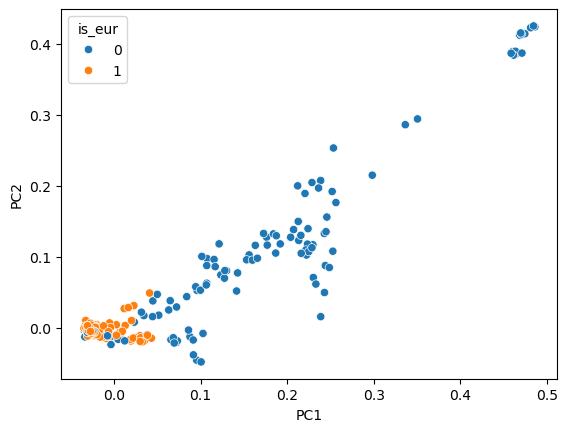

In [18]:
import seaborn as sb

plt.figure()
sb.scatterplot(data=df_pca_flt, x='PC1', y='PC2', hue='is_eur')
fig_name = dir_fig + 'PC1_vs_PC2.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()

In [ ]:
#########################################
# generate the big table
file_name = 'combined_table.tsv'
df = get_big_table(file_name)
#display(df)

# or read the big table
#file_name = 'test.tsv'
#df = pd.read_table(file_name, sep='\t', header=0)
#########################################

/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:2: DtypeWarning: Columns (25,63,64,68,70,71,75,76,77,78,79,80,81,82,86,87,88,89,90,91,92,93,97,98,99,100,101,102,103,104,108,109,110,111,112,113,114,115,119,120,121,122,123,124,125,126) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_table(file_name, sep='\t', header=0)


stratify samples with both hp1/2 and not complete...
SQ5_SAMPLES
SQ10_SAMPLES
SQ20_SAMPLES
SQ30_SAMPLES
SQ40_SAMPLES
SQ50_SAMPLES
SQ60_SAMPLES
SQ70_SAMPLES
AD2_SAMPLES
AD3_SAMPLES
AD4_SAMPLES
AD5_SAMPLES
s_het 0.1...
s_het subsets 100...
s_het 0.01...
s_het subsets 10...
s_het 0.001...
s_het subsets 1...
GNOCCHI_MAX_4...
GNOCCHI_MAX_4 subsets...
GNOCCHI_MAX_3...
GNOCCHI_MAX_3 subsets...
GNOCCHI_MAX_2...
GNOCCHI_MAX_2 subsets...
GNOCCHI_MAX_1...
GNOCCHI_MAX_1 subsets...
GNOCCHI_MEAN_4...
GNOCCHI_MEAN_4 subsets...
GNOCCHI_MEAN_3...
GNOCCHI_MEAN_3 subsets...
GNOCCHI_MEAN_2...
GNOCCHI_MEAN_2 subsets...
GNOCCHI_MEAN_1...
GNOCCHI_MEAN_1 subsets...
EV_CONS_EL_BP_1...
EV_CONS_EL_BP_50...
EV_CONS_EL_BP_100...
EV_CONS_EL_FRAC_2...
EV_CONS_EL_FRAC_5...
EV_CONS_EL_FRAC_10...
frequence calc...
   AD2_SAMPLES
   AD3_SAMPLES
   AD4_SAMPLES
   AD5_SAMPLES
   SQ5_SAMPLES
   SQ10_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'freq_{col}'] = df.apply(lambda row: get_freq(row, col, parents_set_lr, parents_set_sr), axis=1)


   SQ20_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'freq_{col}'] = df.apply(lambda row: get_freq(row, col, parents_set_lr, parents_set_sr), axis=1)


   SQ30_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'freq_{col}'] = df.apply(lambda row: get_freq(row, col, parents_set_lr, parents_set_sr), axis=1)


   SQ40_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'freq_{col}'] = df.apply(lambda row: get_freq(row, col, parents_set_lr, parents_set_sr), axis=1)


   SQ50_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'freq_{col}'] = df.apply(lambda row: get_freq(row, col, parents_set_lr, parents_set_sr), axis=1)


   SQ60_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'freq_{col}'] = df.apply(lambda row: get_freq(row, col, parents_set_lr, parents_set_sr), axis=1)


   SQ70_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:108: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'freq_{col}'] = df.apply(lambda row: get_freq(row, col, parents_set_lr, parents_set_sr), axis=1)


count the number of samples in filter columns...
ZERO_COV_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)


SQ5_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)


SQ10_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)


SQ20_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)


SQ30_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)


SQ40_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)


SQ50_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)


SQ60_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)


SQ70_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)


AD2_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)


AD3_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)


AD4_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)


AD5_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)


HET_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)


HOMALT_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)


IL_SAMPLES


/scratch/smmortazavi/job_34492899/ipykernel_95917/2896170977.py:116: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'NUM_{col}'] = df.apply(lambda row: count_num(row, col), axis=1)


count number of case/control...


In [11]:
def get_df_flt(df, flt_name, svtypes, ext_col=None, flt_sd_art=True, freq_col=None, freq_thr=None):
    if not ext_col:
        df_flt = df.loc[((df[f'NUM_{flt_name}'] > 0) | (df['NUM_IL_SAMPLES'] > 0)) & (df.SVTYPE.isin(svtypes))]
    else:
        df_flt = df.loc[((df[f'NUM_{flt_name}'] > 0) | (df['NUM_IL_SAMPLES'] > 0)) & (df.SVTYPE.isin(svtypes)) & (df[ext_col]==1)]
    if flt_sd_art:
        df_flt = df_flt.loc[~((df_flt.SD_ART==1) & (df_flt.PLATFORM=='LR'))]
    if freq_thr != None:
        df_flt = df_flt.loc[df_flt[f'freq_{freq_col}']<=freq_thr]
    return df_flt

In [35]:
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

print(f'total: {df.loc[(df.SVTYPE.isin(include_svtypes))].shape}')

df_flt = df.loc[(df.PLATFORM == 'IL') & (df.SVTYPE.isin(include_svtypes))]
print(df_flt.shape)

include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']
df_flt = df.loc[(df.PLATFORM != 'IL') & (df.SVTYPE.isin(include_svtypes))]
print(df_flt.shape)

flt_name = 'AD3_SAMPLES'

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=1)
df_flt_IL = df_flt.loc[df_flt.PLATFORM=='IL']
df_flt_nIL = df_flt.loc[df_flt.PLATFORM!='IL']
print(f'total: {df.shape}')
print(f'filtered all: {df_flt.shape}')
print(f'filtered IL: {df_flt_IL.shape}')
print(f'filtered nIL: {df_flt_nIL.shape}')

total: (257137, 323)
(14524, 323)
(242613, 323)
total: (344736, 323)
filtered all: (43240, 323)
filtered IL: (14524, 323)
filtered nIL: (28716, 323)


In [26]:
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

total: (344736, 323)
filtered: (43240, 323)
total: (344736, 323)
filtered: (27669, 323)


In [14]:
biotypes = ['lncRNA' ,'miRNA' ,'misc_RNA' ,'processed_transcript' ,'snoRNA' ,'snRNA' ,'TEC', 'protein_coding']
pc_subsec = ['protein_coding_cds', 'protein_coding_utr', 'protein_coding_intron', 
             'protein_coding_cds_pli', 'protein_coding_cds_loeuf', 
             'protein_coding_cds_fdr_asd', 'protein_coding_cds_fdr_dd', 'protein_coding_cds_fdr_ndd']
consts_1 = ['PLI', 'LOEUF', 'FDR_ASD', 'FDR_DD', 'FDR_NDD', 'intergenic', 'genic']
consts_2 = ['FB_PR', 'FB_ENH', 'FANTOM']
consts_3 = ['GNOCCHI_MAX_1', 'GNOCCHI_MAX_2', 'GNOCCHI_MAX_3', 'GNOCCHI_MAX_4', 
            'GNOCCHI_MEAN_1', 'GNOCCHI_MEAN_2', 'GNOCCHI_MEAN_3', 'GNOCCHI_MEAN_4']
consts_3_subsec = ['GNOCCHI_MAX_4_cds', 'GNOCCHI_MAX_4_utr', 'GNOCCHI_MAX_4_intron', 
                   'GNOCCHI_MAX_3_cds', 'GNOCCHI_MAX_3_utr', 'GNOCCHI_MAX_3_intron', 
                   'GNOCCHI_MAX_2_cds', 'GNOCCHI_MAX_2_utr', 'GNOCCHI_MAX_2_intron']
consts_4 = ['EV_CONS_EL_BP_1', 'EV_CONS_EL_BP_50', 'EV_CONS_EL_BP_100', 
            'EV_CONS_EL_FRAC_2', 'EV_CONS_EL_FRAC_5', 'EV_CONS_EL_FRAC_10', 'S_HET_1', 'S_HET_10', 'S_HET_100']
consts_4_subsec1 = ['EV_CONS_EL_BP_1_cds', 'EV_CONS_EL_BP_1_utr', 'EV_CONS_EL_BP_1_ncd', 
                   'EV_CONS_EL_BP_50_cds', 'EV_CONS_EL_BP_50_utr', 'EV_CONS_EL_BP_50_ncd', 
                   'EV_CONS_EL_BP_100_cds', 'EV_CONS_EL_BP_100_utr', 'EV_CONS_EL_BP_100_ncd',
                   'S_HET_1_cds', 'S_HET_1_utr', 'S_HET_1_intron', 
                    'S_HET_10_cds', 'S_HET_10_utr', 'S_HET_10_intron', 
                    'S_HET_100_cds', 'S_HET_100_utr', 'S_HET_100_intron']
#consts_4_subsec2 = ['EV_CONS_EL_FRAC_10_cds', 'EV_CONS_EL_FRAC_10_utr', 'EV_CONS_EL_FRAC_10_ncd', 
#                   'EV_CONS_EL_FRAC_20_cds', 'EV_CONS_EL_FRAC_20_utr', 'EV_CONS_EL_FRAC_20_ncd', 
#                   'EV_CONS_EL_FRAC_30_cds', 'EV_CONS_EL_FRAC_30_utr', 'EV_CONS_EL_FRAC_30_ncd']
consts_4_subsec2 = ['EV_CONS_EL_FRAC_2_cds', 'EV_CONS_EL_FRAC_2_utr', 'EV_CONS_EL_FRAC_2_ncd', 
                   'EV_CONS_EL_FRAC_5_cds', 'EV_CONS_EL_FRAC_5_utr', 'EV_CONS_EL_FRAC_5_ncd', 
                   'EV_CONS_EL_FRAC_10_cds', 'EV_CONS_EL_FRAC_10_utr', 'EV_CONS_EL_FRAC_10_ncd']
consts_subsec_1 = ['PLI_cds', 'PLI_utr', 'PLI_intron', 
                   'LOEUF_cds', 'LOEUF_utr', 'LOEUF_intron', 
                   'genic_cds', 'genic_utr', 'genic_intron']
consts_subsec_2 = ['FDR_ASD_cds', 'FDR_ASD_utr', 'FDR_ASD_intron', 
                   'FDR_DD_cds', 'FDR_DD_utr', 'FDR_DD_intron', 
                   'FDR_NDD_cds', 'FDR_NDD_utr', 'FDR_NDD_intron']
consts_subsec_3 = ['PLIp9_cds', 'PLIp9_utr', 'PLIp9_intron',
                   'LOWPLI_cds', 'LOWPLI_utr', 'LOWPLI_intron']
dev_br_10 = ['DEV_BR_GENE_10', 'DEV_BR_GENE_10_cds', 'DEV_BR_GENE_10_utr', 'DEV_BR_GENE_10_intron']
dev_br_20 = ['DEV_BR_GENE_20', 'DEV_BR_GENE_20_cds', 'DEV_BR_GENE_20_utr', 'DEV_BR_GENE_20_intron']
dev_br_30 = ['DEV_BR_GENE_30', 'DEV_BR_GENE_30_cds', 'DEV_BR_GENE_30_utr', 'DEV_BR_GENE_30_intron']
dev_br_40 = ['DEV_BR_GENE_40', 'DEV_BR_GENE_40_cds', 'DEV_BR_GENE_40_utr', 'DEV_BR_GENE_40_intron']
dev_br_50 = ['DEV_BR_GENE_50', 'DEV_BR_GENE_50_cds', 'DEV_BR_GENE_50_utr', 'DEV_BR_GENE_50_intron']
lof_dev_br = ['LOF_DEV_BR_50_cds', 'LOF_DEV_BR_40_cds', 'LOF_DEV_BR_30_cds', 'LOF_DEV_BR_20_cds', 'LOF_DEV_BR_10_cds']
lof_plus_consts = ['LOF_DEV_BR_10_cds', 'LOF_PLI_cds', 'PLI_cds', 'PLI_utr', 'PLI_intron',
                   'LOF_LOEUF_cds', 'LOEUF_cds', 'LOEUF_utr', 'LOEUF_intron']
lof_plus_consts2 = ['LOF_DEV_BR_10_cds', 'LOF_PLI_cds', 'PLI_cds', 'PLI_utr', 'PLI_intron',
                   'LOF_LOWPLI_cds',  'LOWPLI_cds', 'LOWPLI_utr', 'LOWPLI_intron']
lof_plus_consts3 = ['LOF_PLIp9_cds', 'PLIp9_cds', 'PLIp9_utr', 'PLIp9_intron']
lof_plus_consts4 = ['LOF_FDR_ASD_cds', 'LOF_FDR_DD_cds', 'LOF_FDR_NDD_cds']
lof_plus_consts5 = ['PLIp9_LOF_DEV_BR_10_cds', 
                    'PLIp9_DEV_BR_GENE_10', 
                    'PLIp9_DEV_BR_GENE_10_cds', 'PLIp9_DEV_BR_GENE_10_utr', 'PLIp9_DEV_BR_GENE_10_intron']

In [16]:
# SNV carrier samples

print(f"Number of SNV carrier samples: {df_pca_flt['SNV_CAR'].sum()}")
print(df_pca_flt.loc[df_pca_flt.SNV_CAR==1]['Platform'].value_counts())

#print('SNV carriers with ONT')
#display(df_target.loc[(df_target.SNV_CAR==1)&(df_target.Platform=="ONT")])
#print('SNV carriers with PB')
#display(df_target.loc[(df_target.SNV_CAR==1)&(df_target.Platform=="PB")])
#display(df_target)

Number of SNV carrier samples: 85
Platform
PB     48
ONT    37
Name: count, dtype: int64


In [15]:
### write counts for each sample for R script

fts = (consts_1 + consts_2 + consts_3 + consts_3_subsec + consts_4 + consts_4_subsec1 + consts_4_subsec2 + consts_subsec_1 + consts_subsec_2 + 
       dev_br_10 + dev_br_20 + dev_br_30 + dev_br_40 + dev_br_50 + lof_dev_br + 
       lof_plus_consts + lof_plus_consts2 + lof_plus_consts3 + lof_plus_consts4 + lof_plus_consts5)

flt_names = ['AD5_SAMPLES', 'AD4_SAMPLES', 'AD3_SAMPLES', 
             'SQ20_SAMPLES', 'SQ30_SAMPLES', 'SQ40_SAMPLES', 'SQ50_SAMPLES', 'SQ60_SAMPLES', 'SQ70_SAMPLES']
#flt_names = ['SQ40_SAMPLES', 'SQ50_SAMPLES', 'SQ60_SAMPLES', 'SQ70_SAMPLES']
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

#samples_col = 'SQ20_SAMPLES'
samples_col = 'AD2_SAMPLES'
#samples_col = 'AD3_SAMPLES'
#samples_col = 'SQ30_SAMPLES'
#samples_col = 'SQ40_SAMPLES'

freq_col = 'AD2_SAMPLES'

for flt_name in flt_names:
    print(flt_name)
    #samples_col = flt_name
    # filter for main svtypes and quality
    df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=0.05)
    print(f'total: {df.shape}')
    print(f'filtered: {df_flt.shape}')
    df_main = pd.DataFrame(df_pca_flt)
    for ft in fts:
        #print(ft)
        this_df = df_flt.loc[df_flt[f'X_{ft}'] == 1]
        temp = this_df[samples_col].str.split(',').tolist() + this_df['IL_SAMPLES_LR'].str.split(',').tolist()
        this_samples_list = []
        for x in temp:
            this_samples_list.extend(x)
        count_col = []
        for sample in df_pca_flt.iid.tolist():
            count_col.append(this_samples_list.count(sample))
        df_main[f'count_{ft}'] = count_col

    #display(df_main)
    file_out = 'main_df_toR_freq05_LRIL_'+flt_name+'_'+samples_col+'.csv'
    print(f'writing {file_out}')
    df_main.to_csv(file_out, sep=',', header=True, index=False)
print('+'*40)

AD5_SAMPLES
total: (344736, 456)
filtered: (18219, 456)


/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

writing main_df_toR_freq05_LRIL_AD5_SAMPLES_AD2_SAMPLES.csv
AD4_SAMPLES
total: (344736, 456)
filtered: (20855, 456)


/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

writing main_df_toR_freq05_LRIL_AD4_SAMPLES_AD2_SAMPLES.csv
AD3_SAMPLES
total: (344736, 456)
filtered: (25670, 456)


/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

writing main_df_toR_freq05_LRIL_AD3_SAMPLES_AD2_SAMPLES.csv
SQ20_SAMPLES
total: (344736, 456)
filtered: (26506, 456)


/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

writing main_df_toR_freq05_LRIL_SQ20_SAMPLES_AD2_SAMPLES.csv
SQ30_SAMPLES
total: (344736, 456)
filtered: (22360, 456)


/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

writing main_df_toR_freq05_LRIL_SQ30_SAMPLES_AD2_SAMPLES.csv
SQ40_SAMPLES
total: (344736, 456)
filtered: (20483, 456)


/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

writing main_df_toR_freq05_LRIL_SQ40_SAMPLES_AD2_SAMPLES.csv
SQ50_SAMPLES
total: (344736, 456)
filtered: (18701, 456)


/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

writing main_df_toR_freq05_LRIL_SQ50_SAMPLES_AD2_SAMPLES.csv
SQ60_SAMPLES
total: (344736, 456)
filtered: (17623, 456)


/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

writing main_df_toR_freq05_LRIL_SQ60_SAMPLES_AD2_SAMPLES.csv
SQ70_SAMPLES
total: (344736, 456)
filtered: (16430, 456)


/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

writing main_df_toR_freq05_LRIL_SQ70_SAMPLES_AD2_SAMPLES.csv
++++++++++++++++++++++++++++++++++++++++


/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_34015340/ipykernel_751387/4038730218.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

In [19]:
### write counts for each sample for R script, INS/DUP

fts = (consts_1 + consts_2 + consts_3 + consts_3_subsec + consts_4 + consts_4_subsec1 + consts_4_subsec2 + consts_subsec_1 + consts_subsec_2 + 
       dev_br_10 + dev_br_20 + dev_br_30 + dev_br_40 + dev_br_50 + lof_dev_br + 
       lof_plus_consts + lof_plus_consts2 + lof_plus_consts3 + lof_plus_consts4 + lof_plus_consts5)

flt_names = ['AD5_SAMPLES', 'AD4_SAMPLES', 'AD3_SAMPLES', 
             'SQ20_SAMPLES', 'SQ30_SAMPLES', 'SQ40_SAMPLES', 'SQ50_SAMPLES', 'SQ60_SAMPLES', 'SQ70_SAMPLES']
#flt_names = ['SQ40_SAMPLES', 'SQ50_SAMPLES', 'SQ60_SAMPLES', 'SQ70_SAMPLES']
#include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']
include_svtypes = ['INS', 'DUP', '.']

#samples_col = 'SQ20_SAMPLES'
samples_col = 'AD2_SAMPLES'
#samples_col = 'AD3_SAMPLES'
#samples_col = 'SQ30_SAMPLES'
#samples_col = 'SQ40_SAMPLES'

freq_col = 'AD2_SAMPLES'

for flt_name in flt_names:
    print(flt_name)
    #samples_col = flt_name
    # filter for main svtypes and quality
    df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=0.05)
    print(f'total: {df.shape}')
    print(f'filtered: {df_flt.shape}')
    df_main = pd.DataFrame(df_pca_flt)
    for ft in fts:
        #print(ft)
        this_df = df_flt.loc[df_flt[f'X_{ft}'] == 1]
        temp = this_df[samples_col].str.split(',').tolist() + this_df['IL_SAMPLES_LR'].str.split(',').tolist()
        this_samples_list = []
        for x in temp:
            this_samples_list.extend(x)
        count_col = []
        for sample in df_pca_flt.iid.tolist():
            count_col.append(this_samples_list.count(sample))
        df_main[f'count_{ft}'] = count_col

    #display(df_main)
    #file_out = 'main_df_toR_freq05_LRIL_'+flt_name+'_'+samples_col+'.csv'
    file_out = 'main_df_toR_freq05_LRIL_'+flt_name+'_'+samples_col+'_INSDUP'+'.csv'
    print(f'writing {file_out}')
    df_main.to_csv(file_out, sep=',', header=True, index=False)
print('+'*40)

AD5_SAMPLES
total: (344736, 451)
filtered: (7338, 451)


/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

writing main_df_toR_freq05_LRIL_AD5_SAMPLES_AD2_SAMPLES_INSDUP.csv
AD4_SAMPLES
total: (344736, 451)
filtered: (9139, 451)


/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

writing main_df_toR_freq05_LRIL_AD4_SAMPLES_AD2_SAMPLES_INSDUP.csv
AD3_SAMPLES
total: (344736, 451)
filtered: (12823, 451)


/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

writing main_df_toR_freq05_LRIL_AD3_SAMPLES_AD2_SAMPLES_INSDUP.csv
SQ20_SAMPLES
total: (344736, 451)
filtered: (13081, 451)


/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

writing main_df_toR_freq05_LRIL_SQ20_SAMPLES_AD2_SAMPLES_INSDUP.csv
SQ30_SAMPLES
total: (344736, 451)
filtered: (9996, 451)


/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

writing main_df_toR_freq05_LRIL_SQ30_SAMPLES_AD2_SAMPLES_INSDUP.csv
SQ40_SAMPLES
total: (344736, 451)
filtered: (8664, 451)


/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

writing main_df_toR_freq05_LRIL_SQ40_SAMPLES_AD2_SAMPLES_INSDUP.csv
SQ50_SAMPLES
total: (344736, 451)
filtered: (7569, 451)


/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

writing main_df_toR_freq05_LRIL_SQ50_SAMPLES_AD2_SAMPLES_INSDUP.csv
SQ60_SAMPLES
total: (344736, 451)
filtered: (6888, 451)


/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

writing main_df_toR_freq05_LRIL_SQ60_SAMPLES_AD2_SAMPLES_INSDUP.csv
SQ70_SAMPLES
total: (344736, 451)
filtered: (6212, 451)


/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

writing main_df_toR_freq05_LRIL_SQ70_SAMPLES_AD2_SAMPLES_INSDUP.csv
++++++++++++++++++++++++++++++++++++++++


/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/277615702.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

In [20]:
### write counts for each sample for R script, DEL

fts = (consts_1 + consts_2 + consts_3 + consts_3_subsec + consts_4 + consts_4_subsec1 + consts_4_subsec2 + consts_subsec_1 + consts_subsec_2 + 
       dev_br_10 + dev_br_20 + dev_br_30 + dev_br_40 + dev_br_50 + lof_dev_br + 
       lof_plus_consts + lof_plus_consts2 + lof_plus_consts3 + lof_plus_consts4 + lof_plus_consts5)

flt_names = ['AD5_SAMPLES', 'AD4_SAMPLES', 'AD3_SAMPLES', 
             'SQ20_SAMPLES', 'SQ30_SAMPLES', 'SQ40_SAMPLES', 'SQ50_SAMPLES', 'SQ60_SAMPLES', 'SQ70_SAMPLES']
#flt_names = ['SQ40_SAMPLES', 'SQ50_SAMPLES', 'SQ60_SAMPLES', 'SQ70_SAMPLES']
#include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']
include_svtypes = ['DEL']

#samples_col = 'SQ20_SAMPLES'
samples_col = 'AD2_SAMPLES'
#samples_col = 'AD3_SAMPLES'
#samples_col = 'SQ30_SAMPLES'
#samples_col = 'SQ40_SAMPLES'

freq_col = 'AD2_SAMPLES'

for flt_name in flt_names:
    print(flt_name)
    #samples_col = flt_name
    # filter for main svtypes and quality
    df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=0.05)
    print(f'total: {df.shape}')
    print(f'filtered: {df_flt.shape}')
    df_main = pd.DataFrame(df_pca_flt)
    for ft in fts:
        #print(ft)
        this_df = df_flt.loc[df_flt[f'X_{ft}'] == 1]
        temp = this_df[samples_col].str.split(',').tolist() + this_df['IL_SAMPLES_LR'].str.split(',').tolist()
        this_samples_list = []
        for x in temp:
            this_samples_list.extend(x)
        count_col = []
        for sample in df_pca_flt.iid.tolist():
            count_col.append(this_samples_list.count(sample))
        df_main[f'count_{ft}'] = count_col

    #display(df_main)
    #file_out = 'main_df_toR_freq05_LRIL_'+flt_name+'_'+samples_col+'.csv'
    file_out = 'main_df_toR_freq05_LRIL_'+flt_name+'_'+samples_col+'_DEL'+'.csv'
    print(f'writing {file_out}')
    df_main.to_csv(file_out, sep=',', header=True, index=False)
print('+'*40)

AD5_SAMPLES
total: (344736, 451)
filtered: (10697, 451)


/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

writing main_df_toR_freq05_LRIL_AD5_SAMPLES_AD2_SAMPLES_DEL.csv
AD4_SAMPLES
total: (344736, 451)
filtered: (11484, 451)


/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

writing main_df_toR_freq05_LRIL_AD4_SAMPLES_AD2_SAMPLES_DEL.csv
AD3_SAMPLES
total: (344736, 451)
filtered: (12525, 451)


/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

writing main_df_toR_freq05_LRIL_AD3_SAMPLES_AD2_SAMPLES_DEL.csv
SQ20_SAMPLES
total: (344736, 451)
filtered: (13098, 451)


/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

writing main_df_toR_freq05_LRIL_SQ20_SAMPLES_AD2_SAMPLES_DEL.csv
SQ30_SAMPLES
total: (344736, 451)
filtered: (12142, 451)


/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

writing main_df_toR_freq05_LRIL_SQ30_SAMPLES_AD2_SAMPLES_DEL.csv
SQ40_SAMPLES
total: (344736, 451)
filtered: (11626, 451)


/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

writing main_df_toR_freq05_LRIL_SQ40_SAMPLES_AD2_SAMPLES_DEL.csv
SQ50_SAMPLES
total: (344736, 451)
filtered: (10973, 451)


/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

writing main_df_toR_freq05_LRIL_SQ50_SAMPLES_AD2_SAMPLES_DEL.csv
SQ60_SAMPLES
total: (344736, 451)
filtered: (10587, 451)


/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

writing main_df_toR_freq05_LRIL_SQ60_SAMPLES_AD2_SAMPLES_DEL.csv
SQ70_SAMPLES
total: (344736, 451)
filtered: (10089, 451)


/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

writing main_df_toR_freq05_LRIL_SQ70_SAMPLES_AD2_SAMPLES_DEL.csv
++++++++++++++++++++++++++++++++++++++++


/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_main[f'count_{ft}'] = count_col
/scratch/smmortazavi/job_33929244/ipykernel_2272708/2954152306.py:39: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

In [12]:
### write calls in interesting categories to export to sheets

#flt_name = 'AD3_SAMPLES'
#flt_name = 'AD4_SAMPLES'
#flt_name = 'SQ20_SAMPLES'
flt_name = 'SQ70_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']
freq_col = 'AD2_SAMPLES'

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_col=freq_col, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

#fts = (biotypes + pc_subsec + consts_1 + consts_2 + consts_subsec_1 + consts_subsec_2 + 
#       dev_br_10 + dev_br_20 + dev_br_30 + dev_br_40 + dev_br_50 + lof_dev_br + 
#       lof_plus_consts + lof_plus_consts2 + lof_plus_consts3 + lof_plus_consts4 + lof_plus_consts5)

#fts = ['PLIp9_LOF_DEV_BR_10_cds', 'LOF_DEV_BR_10_cds', 
#       'LOF_PLIp9_cds', 'LOF_LOWPLI_cds', 'LOF_PLI_cds', 
#       'LOF_LOEUF_cds', 
#       'LOF_FDR_ASD_cds', 'LOF_FDR_DD_cds', 'LOF_FDR_NDD_cds', 
#       'PLIp9_DEV_BR_GENE_10', 'PLIp9_DEV_BR_GENE_10_cds', 'PLIp9_DEV_BR_GENE_10_utr', 'PLIp9_DEV_BR_GENE_10_intron', 
#       'DEV_BR_GENE_10', 'DEV_BR_GENE_10_cds', 'DEV_BR_GENE_10_utr', 'DEV_BR_GENE_10_intron', 
#       'PLIp9', 'PLIp9_cds', 'PLIp9_utr', 'PLIp9_intron', 
#       'LOWPLI', 'LOWPLI_cds', 'LOWPLI_utr', 'LOWPLI_intron', 
#       'PLI', 'PLI_cds', 'PLI_utr', 'PLI_intron', 
#       'LOEUF', 'LOEUF_cds', 'LOEUF_utr', 'LOEUF_intron',  
#       'FDR_ASD', 'FDR_ASD_cds', 'FDR_ASD_utr', 'FDR_ASD_intron',
#       'FDR_DD', 'FDR_DD_cds', 'FDR_DD_utr', 'FDR_DD_intron', 
#       'FDR_NDD', 'FDR_NDD_cds', 'FDR_NDD_utr', 'FDR_NDD_intron', 
#       'FB_PR', 'FB_ENH', 'FANTOM', 'GNOCCHI_1', 'GNOCCHI_2', 'GNOCCHI_3', 'GNOCCHI_4']
fts = ['PLIp9_DEV_BR_GENE_10_cds', 'PLIp9_DEV_BR_GENE_10_utr', 'PLIp9_DEV_BR_GENE_10_intron', 
       'DEV_BR_GENE_10_cds', 'DEV_BR_GENE_10_utr', 'DEV_BR_GENE_10_intron', 
       'PLIp9_cds', 'PLIp9_utr', 'PLIp9_intron', 
       'LOWPLI_cds', 'LOWPLI_utr', 'LOWPLI_intron', 'intergenic', 'genic', 'genic_cds', 'genic_utr', 'genic_intron']

cols_clean = ['CHROM', 'POS', 'END', 'ID', 'SVTYPE', 'PLATFORM', 'SVLEN', 'SRC', 'GENCODE', 'denovo_LR', 'denovo_LR_LC', 
              'MAT_INH_LR', 'MAT_INH_LR_LC', 'PAT_INH_LR', 'PAT_INH_LR_LC', 'PMAT_INH_LR_LC', 'denovo_IL', 'denovo_IL_LC', 
              'MAT_INH_IL', 'PAT_INH_IL', 'PMAT_INH_IL', 'AC', 'PASS_STRICT', 'TR50', 'SD50', 'HWP', 
              'SQ5_SAMPLES', 'SQ10_SAMPLES', 'SQ20_SAMPLES', 'SQ30_SAMPLES', 'SQ40_SAMPLES', 'SQ50_SAMPLES', 'SQ60_SAMPLES', 'SQ70_SAMPLES', 
              'AD2_SAMPLES', 'AD3_SAMPLES', 'AD4_SAMPLES', 'AD5_SAMPLES',
              'HET_SAMPLES', 'HOMALT_SAMPLES', 'gnomadV4_AF', 'gnomadV4_PC', 'gnomadV4_POPMAX_AF', 'gnomadV4_name', 
              'GNOCCHI', 'FB_PR_ENH_M', 'FB_PR_ENH_F', 'FANTOM_ENH', 'Consequence', 'IMPACT', 'SYMBOL', 'GENE', 'BIOTYPE', 'DISTANCE', 
              'TSSDistance', 'LOF_DUP_INV', 'LOF_DUP_INV_GENES', 'SD_ART', 'SD_SEG1', 'SD_SEG2', 
              'GENES_PLI', 'MAX_PLI', 'MAX_PLI_GENE', 'GENES_LOEUF', 'MIN_LOEUF', 'MIN_LOEUF_GENE', 
              'GENES_FDR_ASD', 'MIN_FDR_ASD', 'MIN_FDR_ASD_GENE', 'GENES_FDR_DD', 'MIN_FDR_DD', 'MIN_FDR_DD_GENE', 
              'GENES_FDR_NDD', 'MIN_FDR_NDD', 'MIN_FDR_NDD_GENE']

write_plots = False
for ft in fts:
    this_df_flt = df_flt.loc[(df_flt[f'X_{ft}']==1)]
    #file_out = f'data_tables/table_{ft}_{flt_name}.tsv'
    #file_out = f'data_tables/clean_tables/table_{ft}_{flt_name}.tsv'
    file_out = f'data_tables/clean_tables/SQ70/table_{ft}_{flt_name}.tsv'
    print(file_out)
    this_df_flt[cols_clean].to_csv(file_out, sep='\t', header=True, index=False)
    print(f'this_df_flt shape: {this_df_flt.shape}')

    if write_plots:
        # to show the count of each sample show this column
        flt_name = 'AD2_SAMPLES'
        samples_cases_list = ['|'.join([y, plat_dict[y]]) for xs, cs in zip(this_df_flt[flt_name].str.split(',').tolist(), 
                                                                            this_df_flt[f'case_{flt_name}'].str.split(',').tolist()) 
                              for y, c in zip(xs, cs) if c=='Yes']
        samples_controls_list = ['|'.join([y, plat_dict[y]]) for xs, cs in zip(this_df_flt[flt_name].str.split(',').tolist(), 
                                                                               this_df_flt[f'case_{flt_name}'].str.split(',').tolist()) 
                                 for y, c in zip(xs, cs) if c=='No']
    
        df_cases = pd.DataFrame({'samples': samples_cases_list})
        case_count_nums = df_cases.value_counts().tolist()
        case_count_samples = df_cases.value_counts().index.get_level_values(0).tolist()
        #print('count cases:')
        #print(case_count_nums)
        #print(case_count_samples)
    
        df_controls = pd.DataFrame({'samples': samples_controls_list})
        control_count_nums = df_controls.value_counts().tolist()
        control_count_samples = df_controls.value_counts().index.get_level_values(0).tolist()
        #print('count controls:')
        #print(control_count_nums)
        #print(control_count_samples)

        fig, ax = plt.subplots()
        ax.bar(case_count_samples, case_count_nums)
        ax.set_xticks(case_count_samples, case_count_samples, rotation=90, fontsize=4)
        ax.set_aspect('auto')
        plt.ylabel('Counts')
        plt.title(f'cases, sum N: {df_cases.shape[0]}, {ft}')
        #fig_name = f'sample_case_lzs{lzs_trg}_{ft}'
        fig_name = f'sample_case_{flt_name}_{ft}_counts_hist'
        plt.savefig(fig_name+'.png', bbox_inches='tight')
        plt.savefig(fig_name+'.pdf', bbox_inches='tight')
        plt.show()
        plt.close()

        fig, ax = plt.subplots()
        ax.bar(control_count_samples, control_count_nums)
        ax.set_xticks(control_count_samples, control_count_samples, rotation=90, fontsize=4)
        ax.set_aspect('auto')
        plt.ylabel('Counts')
        plt.title(f'controls, sum N: {df_controls.shape[0]}, {ft}')
        #fig_name = f'sample_control_lzs{lzs_trg}_{ft}'
        fig_name = f'sample_control_{flt_name}_{ft}_counts_hist'
        plt.savefig(fig_name+'.png', bbox_inches='tight')
        plt.savefig(fig_name+'.pdf', bbox_inches='tight')
        plt.show()
        plt.close()

total: (344736, 456)
filtered: (16430, 456)
data_tables/clean_tables/SQ70/table_PLIp9_DEV_BR_GENE_10_cds_SQ70_SAMPLES.tsv
this_df_flt shape: (37, 456)
data_tables/clean_tables/SQ70/table_PLIp9_DEV_BR_GENE_10_utr_SQ70_SAMPLES.tsv
this_df_flt shape: (21, 456)
data_tables/clean_tables/SQ70/table_PLIp9_DEV_BR_GENE_10_intron_SQ70_SAMPLES.tsv
this_df_flt shape: (807, 456)
data_tables/clean_tables/SQ70/table_DEV_BR_GENE_10_cds_SQ70_SAMPLES.tsv
this_df_flt shape: (75, 456)
data_tables/clean_tables/SQ70/table_DEV_BR_GENE_10_utr_SQ70_SAMPLES.tsv
this_df_flt shape: (49, 456)
data_tables/clean_tables/SQ70/table_DEV_BR_GENE_10_intron_SQ70_SAMPLES.tsv
this_df_flt shape: (1438, 456)
data_tables/clean_tables/SQ70/table_PLIp9_cds_SQ70_SAMPLES.tsv
this_df_flt shape: (71, 456)
data_tables/clean_tables/SQ70/table_PLIp9_utr_SQ70_SAMPLES.tsv
this_df_flt shape: (52, 456)
data_tables/clean_tables/SQ70/table_PLIp9_intron_SQ70_SAMPLES.tsv
this_df_flt shape: (2263, 456)
data_tables/clean_tables/SQ70/table_LOWPLI

In [22]:
def plot_tran_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.02, dx2=0.02):
    # plot transmission disequilibrium
    ORs = []
    text_info = []
    chisq_ps = []
    for ft in fts:
        df_w = df_flt.loc[df_flt[f'X_{ft}'] == 1]
        #df_wo = df_flt.loc[df_flt[f'X_{ft}'] == 0]
        print(f'SVs intersecting {ft}: {df_w.shape[0]}')

        tran_case = df_w[f'NUM_tran_case_{flt_name}'].sum()
        tran_control = df_w[f'NUM_tran_control_{flt_name}'].sum()
        nontran_case = df_w[f'NUM_nontran_case_{flt_name}'].sum()
        nontran_control = df_w[f'NUM_nontran_control_{flt_name}'].sum()
        text_info.append('/'.join([str(tran_case), str(nontran_case)]))
        
        OR = (tran_case / tran_control) / (nontran_case / nontran_control)
        #print(f'n_w_ft_case: {n_w_ft_case}, n_w_ft_control: {n_w_ft_control}, n_wo_ft_case: {n_wo_ft_case}, n_wo_ft_control: {n_wo_ft_control}')#print(f'OR: {OR}')
        ORs.append(OR)
        ob = np.array([[tran_case, nontran_case], [tran_control, nontran_control]])
        try:
            chi2_stat, p_val, dof, expected = chi2_contingency(ob)
        except:
            p_val = np.nan
        chisq_ps.append(p_val)
        
    print('case/control chi-squared p-values:')
    print(' '.join(fts))
    print(' '.join([f'{x:.2e}' for x in chisq_ps]))
    plt.figure()
    plt.plot(range(0,len(fts)), ORs, 'Dr', label='All samples')
    for i in range(0,len(fts)):
        plt.text(i, ORs[i]+dx1, text_info[i], rotation=15, fontsize=8)
        plt.text(i, ORs[i]-dx2, f'p: {chisq_ps[i]:.2e}', rotation=15, fontsize=8)
    plt.xticks(range(0,len(fts)), fts, rotation=45, ha='right')
    plt.gca().set_aspect(AR)
    plt.ylabel('Odds ratio')
    plt.title('numbers: #transfer / #non-transfer, to cases')
    #plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    print(fig_name)
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()
    plt.close()

total: (344736, 298)
filtered: (27669, 298)
notebook_svs/transfer_enrich_pli_loeuf_cds.png
SVs intersecting LOF_DEV_BR_10_cds: 87
SVs intersecting LOF_PLI_cds: 64
SVs intersecting PLI_cds: 116
SVs intersecting PLI_utr: 57
SVs intersecting PLI_intron: 3080
SVs intersecting LOF_LOEUF_cds: 37
SVs intersecting LOEUF_cds: 73
SVs intersecting LOEUF_utr: 40
SVs intersecting LOEUF_intron: 2138
case/control chi-squared p-values:
LOF_DEV_BR_10_cds LOF_PLI_cds PLI_cds PLI_utr PLI_intron LOF_LOEUF_cds LOEUF_cds LOEUF_utr LOEUF_intron
3.65e-02 1.29e-02 2.45e-02 9.25e-01 3.75e-02 3.55e-01 8.34e-01 9.04e-01 1.72e-01
notebook_svs/transfer_enrich_pli_loeuf_cds.png


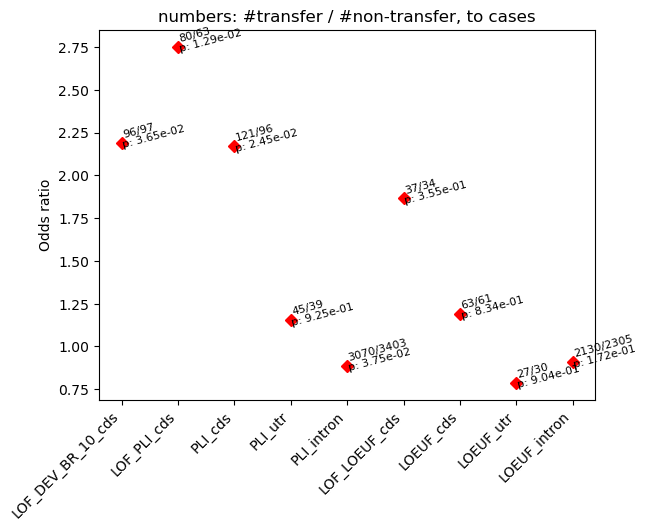

In [24]:
fts = lof_plus_consts
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

fig_name = dir_fig + 'transfer_enrich_pli_loeuf_cds.png'
print(fig_name)
plot_tran_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.03, dx2=0.03)

In [25]:
def plot_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.02, dx2=0.02):
    # plot enrichment in biotypes
    #fts = biotypes
    #fig_name = 'odds_ratio_biotypes.png'
    ORs = []
    text_info = []
    chisq_ps = []
    for ft in fts:
        df_w = df_flt.loc[df_flt[f'X_{ft}'] == 1]
        df_wo = df_flt.loc[df_flt[f'X_{ft}'] == 0]
        print(f'SVs intersecting {ft}: {df_w.shape[0]}')
        
        n_w_ft_case = df_w[f'{flt_name}_CASE_NUM'].sum() + df_w['IL_SAMPLES_CASE_NUM'].sum()
        n_w_ft_control = df_w[f'{flt_name}_CONTROL_NUM'].sum() + df_w['IL_SAMPLES_CONTROL_NUM'].sum()
        n_wo_ft_case = df_wo[f'{flt_name}_CASE_NUM'].sum() + df_wo['IL_SAMPLES_CASE_NUM'].sum()
        n_wo_ft_control = df_wo[f'{flt_name}_CONTROL_NUM'].sum() + df_wo['IL_SAMPLES_CONTROL_NUM'].sum()
        text_info.append('/'.join([str(n_w_ft_case), str(n_w_ft_control)]))
        
        OR = (n_w_ft_case / n_w_ft_control) / (n_wo_ft_case / n_wo_ft_control)
        #print(f'n_w_ft_case: {n_w_ft_case}, n_w_ft_control: {n_w_ft_control}, n_wo_ft_case: {n_wo_ft_case}, n_wo_ft_control: {n_wo_ft_control}')#print(f'OR: {OR}')
        ORs.append(OR)
        ob = np.array([[n_w_ft_case, n_wo_ft_case], [n_w_ft_control, n_wo_ft_control]])
        try:
            chi2_stat, p_val, dof, expected = chi2_contingency(ob)
        except:
            p_val = np.nan
        chisq_ps.append(p_val)
        
    print('case/control chi-squared p-values:')
    print(' '.join(fts))
    print(' '.join([f'{x:.2e}' for x in chisq_ps]))
    #AR = 5
    plt.figure()
    plt.plot(range(0,len(fts)), ORs, 'Dr', label='All samples')
    for i in range(0,len(fts)):
        plt.text(i, ORs[i]+dx1, text_info[i], rotation=15, fontsize=8)
        plt.text(i, ORs[i]-dx2, f'p: {chisq_ps[i]:.2e}', rotation=15, fontsize=8)
    plt.xticks(range(0,len(fts)), fts, rotation=45, ha='right')
    plt.gca().set_aspect(AR)
    plt.ylabel('Odds ratio')
    plt.title('numbers: # cases / # controls, xing features')
    #plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    print(fig_name)
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()
    plt.close()

total: (344736, 298)
filtered: (27669, 298)
notebook_svs/hist_zero_cov_samples.png


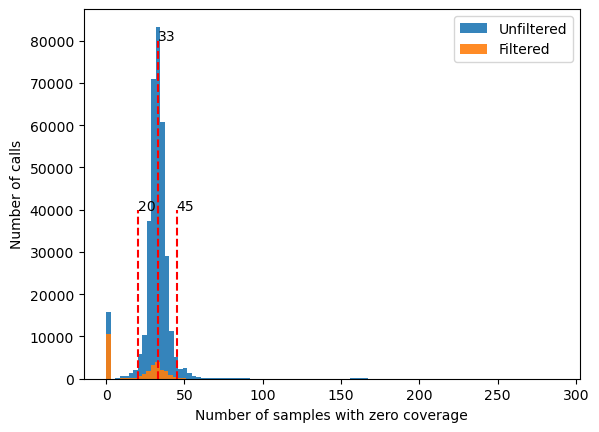

In [36]:
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

plt.figure()
plt.hist(df.NUM_ZERO_COV_SAMPLES, bins=100, label='Unfiltered', alpha=.9)
plt.hist(df_flt.NUM_ZERO_COV_SAMPLES, bins=100, label='Filtered', alpha=.9)

x_val = 45
y_val = 40000
plt.plot([x_val, x_val], [0, y_val], '--r')
plt.text(x_val, y_val, f'{x_val}')	

x_val = 20
y_val = 40000
plt.plot([x_val, x_val], [0, y_val], '--r')
plt.text(x_val, y_val, f'{x_val}')	

x_val = 33
y_val = 80000
plt.plot([x_val, x_val], [0, y_val], '--r')
plt.text(x_val, y_val, f'{x_val}')

plt.xlabel('Number of samples with zero coverage')
plt.ylabel('Number of calls')
plt.legend()
fig_name = dir_fig+'hist_zero_cov_samples.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

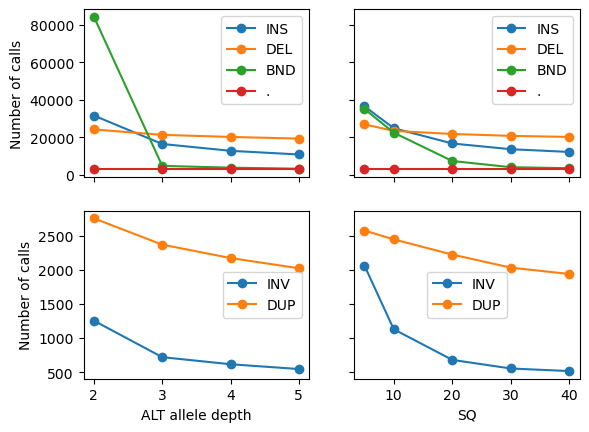

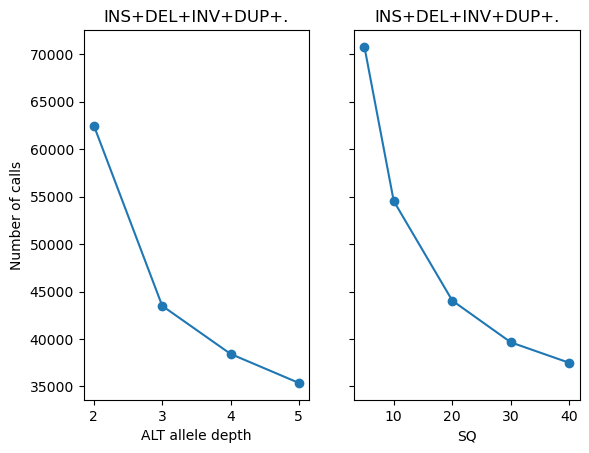

In [40]:
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.', 'BND']

ads = [2, 3, 4, 5]
qs = [5, 10, 20, 30, 40]
sv_counts_ad = []
sv_counts_q = []
for ad in [2, 3, 4, 5]:
    #print(f'++++++++++++ AD{ad} filter ++++++++++')
    #this_df = df.loc[(df[f'NUM_AD{ad}_SAMPLES'] > 0) | (df['NUM_IL_SAMPLES'] > 0)]
    flt_name = f'AD{ad}_SAMPLES'
    this_df = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=False)
    sv_counts_ad.append(this_df.SVTYPE.value_counts())
    #n_pass = this_df.shape[0]
    #print(f'AD{ad} filter, N pass: {n_pass}')
    #print(sv_counts_ad[-1])
    
    #this_df_cov = df.loc[(df[f'NUM_AD{ad}_SAMPLES'] > 0) & (df['NUM_ZERO_COV_SAMPLES'] < N_ZERO_COV_THR)]
    #n_pass_cov = this_df_cov.shape[0]
    #print(this_df_cov.SVTYPE.value_counts())
    #print(f'AD{ad} filter with N_ZERO_COV < {N_ZERO_COV_THR}, N pass: {n_pass_cov}')
    #print()
    
for q in [5, 10, 20, 30, 40]:
    #print(f'++++++++++++ SQ{q} filter ++++++++++')
    #this_df = df.loc[(df[f'NUM_SQ{q}_SAMPLES'] > 0) | (df['NUM_IL_SAMPLES'] > 0)]
    flt_name = f'SQ{q}_SAMPLES'
    this_df = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=False)
    sv_counts_q.append(this_df.SVTYPE.value_counts())
    #n_pass = this_df.shape[0]
    #print(f'SQ{q} filter, N pass: {n_pass}')
    #print(sv_counts_q[-1])
    
    #this_df_cov = df.loc[(df[f'NUM_SQ{q}_SAMPLES'] > 0) & (df['NUM_ZERO_COV_SAMPLES'] < N_ZERO_COV_THR)]
    #n_pass_cov = this_df_cov.shape[0]
    #print(f'SQ{q} filter with N_ZERO_COV < {N_ZERO_COV_THR}, N pass: {n_pass_cov}')
    #print(this_df_cov.SVTYPE.value_counts())
    #print()

###########################
fig, axs = plt.subplots(nrows=2, ncols=2, sharey='row', sharex='col')
svtypes_1 = ['INS', 'DEL', 'BND', '.']
svtypes_2 = ['INV', 'DUP']
for svtype in svtypes_1:
    axs[0, 0].plot(ads, [x[svtype] for x in sv_counts_ad], '-o', label=svtype)
for svtype in svtypes_1:
    axs[0, 1].plot(qs, [x[svtype] for x in sv_counts_q], '-o', label=svtype)
for svtype in svtypes_2:
    axs[1, 0].plot(ads, [x[svtype] for x in sv_counts_ad], '-o', label=svtype)
for svtype in svtypes_2:
    axs[1, 1].plot(qs, [x[svtype] for x in sv_counts_q], '-o', label=svtype)

axs[1, 0].set_xlabel('ALT allele depth')
axs[1, 1].set_xlabel('SQ')
axs[0, 0].set_ylabel('Number of calls')
axs[1, 0].set_ylabel('Number of calls')
axs[0, 0].legend()
axs[0, 1].legend()
axs[1, 0].legend()
axs[1, 1].legend()

fig_name = dir_fig+'filter_calls.png'
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

svtypes = ['INS', 'DEL', 'INV', 'DUP', '.']
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True)
ax1.plot(ads, [x[svtypes].sum() for x in sv_counts_ad], '-o')
ax2.plot(qs, [x[svtypes].sum() for x in sv_counts_q], '-o')
ax1.set_xlabel('ALT allele depth')
ax2.set_xlabel('SQ')
ax1.set_ylabel('Number of calls')
ax1.set_title('+'.join(svtypes))
ax2.set_title('+'.join(svtypes))
fig_name = dir_fig+'filter_calls_total.png'
plt.savefig(fig_name, bbox_inches='tight')
plt.show()
plt.close()

total: (344736, 298)
filtered: (27669, 298)
len(samples_cases_list): 34571
len(samples_controls_list): 24922


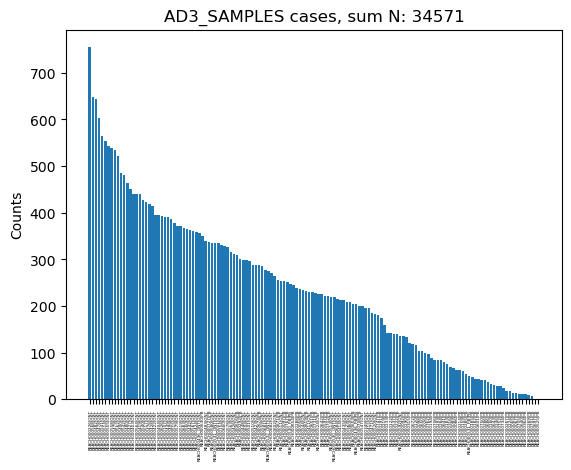

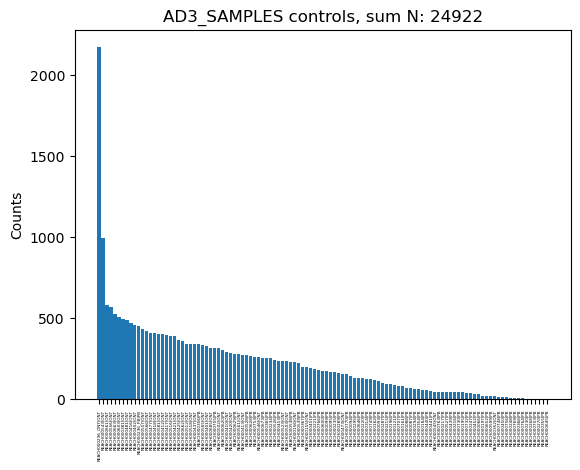

In [45]:
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

#freq_thr=1
freq_thr=0.05

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=freq_thr)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

samples_cases_list = ['|'.join([y, plat_dict[y]]) for xs, cs in zip(df_flt[flt_name].str.split(',').tolist(), 
                                          df_flt[f'case_{flt_name}'].str.split(',').tolist()) 
                      for y, c in zip(xs, cs) if c=='Yes']

samples_controls_list = ['|'.join([y, plat_dict[y]]) for xs, cs in zip(df_flt[flt_name].str.split(',').tolist(), 
                                          df_flt[f'case_{flt_name}'].str.split(',').tolist()) 
                      for y, c in zip(xs, cs) if c=='No']

print('len(samples_cases_list):', len(samples_cases_list))
print('len(samples_controls_list):', len(samples_controls_list))

df_cases = pd.DataFrame({'samples': samples_cases_list})
case_count_nums = df_cases.value_counts().tolist()
case_count_samples = df_cases.value_counts().index.get_level_values(0).tolist()
#print('count cases:')
#print(case_count_nums)
#print(case_count_samples)

df_controls = pd.DataFrame({'samples': samples_controls_list})
control_count_nums = df_controls.value_counts().tolist()
control_count_samples = df_controls.value_counts().index.get_level_values(0).tolist()
#print('count controls:')
#print(control_count_nums)
#print(control_count_samples)

fig, ax = plt.subplots()
ax.bar(case_count_samples, case_count_nums)
ax.set_xticks(case_count_samples, case_count_samples, rotation=90, fontsize=3)
ax.set_aspect('auto')
plt.ylabel('Counts')
plt.title(f'{flt_name} cases, sum N: {df_cases.shape[0]}')
fig_name = dir_fig+f'sample_case_{flt_name}_counts_hist_freq{freq_thr}'
plt.savefig(fig_name+'.png', bbox_inches='tight')
plt.savefig(fig_name+'.pdf', bbox_inches='tight')
plt.show()
plt.close()

fig, ax = plt.subplots()
ax.bar(control_count_samples, control_count_nums)
ax.set_xticks(control_count_samples, control_count_samples, rotation=90, fontsize=3)
ax.set_aspect('auto')
plt.ylabel('Counts')
plt.title(f'{flt_name} controls, sum N: {df_controls.shape[0]}')
fig_name = dir_fig+f'sample_control_{flt_name}_counts_hist_freq{freq_thr}'
plt.savefig(fig_name+'.png', bbox_inches='tight')
plt.savefig(fig_name+'.pdf', bbox_inches='tight')
plt.show()
plt.close()

total: (344736, 298)
filtered: (27669, 298)
SVs intersecting LOF_DEV_BR_10_cds: 87
SVs intersecting LOF_PLI_cds: 64
SVs intersecting PLI_cds: 116
SVs intersecting PLI_utr: 57
SVs intersecting PLI_intron: 3080
SVs intersecting LOF_LOEUF_cds: 37
SVs intersecting LOEUF_cds: 73
SVs intersecting LOEUF_utr: 40
SVs intersecting LOEUF_intron: 2138
case/control chi-squared p-values:
LOF_DEV_BR_10_cds LOF_PLI_cds PLI_cds PLI_utr PLI_intron LOF_LOEUF_cds LOEUF_cds LOEUF_utr LOEUF_intron
1.78e-02 6.42e-02 2.19e-01 5.59e-01 8.17e-02 7.87e-01 3.98e-01 5.13e-01 4.91e-01
notebook_svs/odds_ratio_lof_plus_consts.png


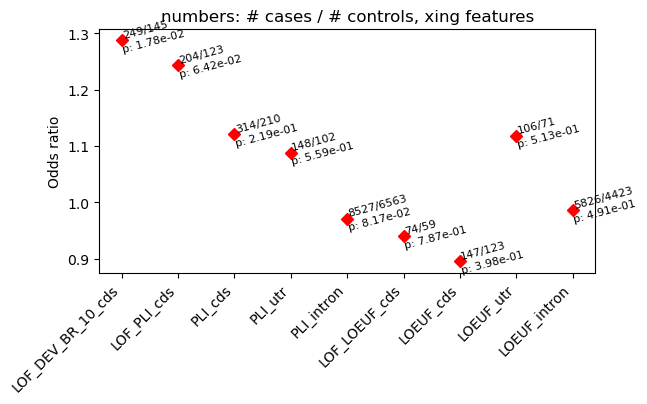

In [47]:
# plot enrichment in lof plus other constraints
fts = lof_plus_consts
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = dir_fig+'odds_ratio_lof_plus_consts.png'
flt_name = 'AD2_SAMPLES'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.005, dx2=0.02)
#plot_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.2, dx2=0.2)

total: (344736, 298)
filtered: (27669, 298)
SVs intersecting PLIp9_LOF_DEV_BR_10_cds: 47
SVs intersecting PLIp9_DEV_BR_GENE_10: 1410
SVs intersecting PLIp9_DEV_BR_GENE_10_cds: 71
SVs intersecting PLIp9_DEV_BR_GENE_10_utr: 30
SVs intersecting PLIp9_DEV_BR_GENE_10_intron: 1309
case/control chi-squared p-values:
PLIp9_LOF_DEV_BR_10_cds PLIp9_DEV_BR_GENE_10 PLIp9_DEV_BR_GENE_10_cds PLIp9_DEV_BR_GENE_10_utr PLIp9_DEV_BR_GENE_10_intron
1.44e-02 9.63e-01 8.54e-02 9.00e-01 7.06e-01
notebook_svs/odds_ratio_lof_plus_consts5.png


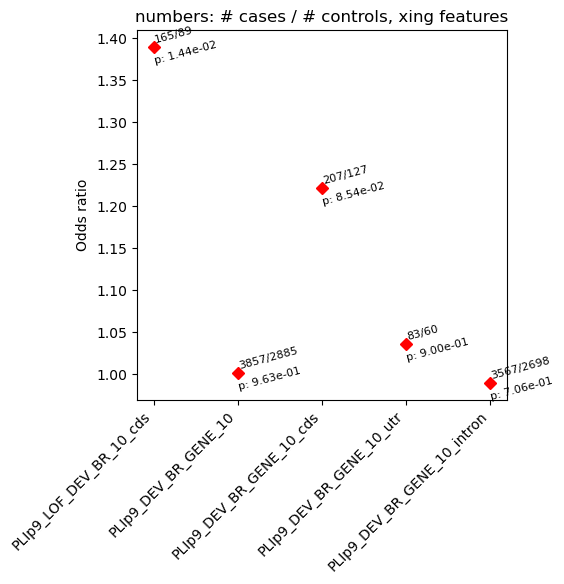

In [49]:
# plot enrichment in lof plus other constraints
fts = lof_plus_consts5
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = dir_fig+'odds_ratio_lof_plus_consts5.png'
flt_name = 'AD2_SAMPLES'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.005, dx2=0.02)
#plot_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.2, dx2=0.2)

total: (344736, 298)
filtered: (27669, 298)
SVs intersecting LOF_DEV_BR_10_cds: 87
SVs intersecting LOF_PLI_cds: 64
SVs intersecting PLI_cds: 116
SVs intersecting PLI_utr: 57
SVs intersecting PLI_intron: 3080
SVs intersecting LOF_LOWPLI_cds: 587
SVs intersecting LOWPLI_cds: 790
SVs intersecting LOWPLI_utr: 287
SVs intersecting LOWPLI_intron: 22713
case/control chi-squared p-values:
LOF_DEV_BR_10_cds LOF_PLI_cds PLI_cds PLI_utr PLI_intron LOF_LOWPLI_cds LOWPLI_cds LOWPLI_utr LOWPLI_intron
1.78e-02 6.42e-02 2.19e-01 5.59e-01 8.17e-02 8.22e-01 2.21e-01 7.77e-01 5.61e-01
notebook_svs/odds_ratio_lof_plus_consts2.png


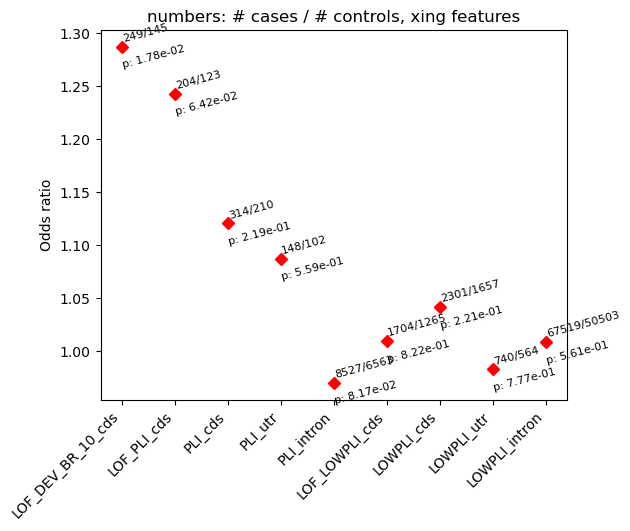

In [50]:
# plot enrichment in lof plus other constraints
fts = lof_plus_consts2
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = dir_fig+'odds_ratio_lof_plus_consts2.png'
flt_name = 'AD2_SAMPLES'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=20, dx1=0.005, dx2=0.02)
#plot_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.2, dx2=0.2)

total: (344736, 298)
filtered: (27669, 298)
SVs intersecting LOF_DEV_BR_50_cds: 13
SVs intersecting LOF_DEV_BR_40_cds: 16
SVs intersecting LOF_DEV_BR_30_cds: 23
SVs intersecting LOF_DEV_BR_20_cds: 57
SVs intersecting LOF_DEV_BR_10_cds: 87
case/control chi-squared p-values:
LOF_DEV_BR_50_cds LOF_DEV_BR_40_cds LOF_DEV_BR_30_cds LOF_DEV_BR_20_cds LOF_DEV_BR_10_cds
1.00e+00 7.72e-01 6.71e-01 2.12e-01 2.43e-02
notebook_svs/odds_ratio_lof_dev_brain.png


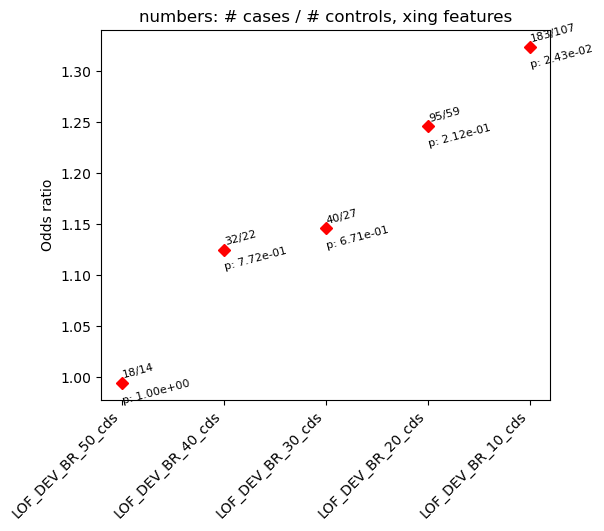

SVs intersecting DEV_BR_GENE_20: 1228
SVs intersecting DEV_BR_GENE_20_cds: 95
SVs intersecting DEV_BR_GENE_20_utr: 30
SVs intersecting DEV_BR_GENE_20_intron: 1103
case/control chi-squared p-values:
DEV_BR_GENE_20 DEV_BR_GENE_20_cds DEV_BR_GENE_20_utr DEV_BR_GENE_20_intron
5.94e-01 8.03e-01 6.43e-01 7.02e-01
notebook_svs/odds_ratio_dev_brain_20.png


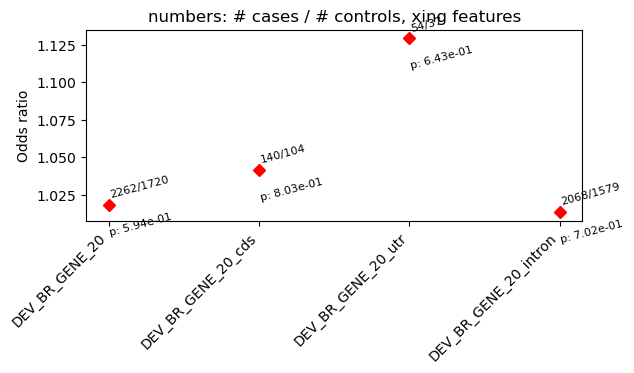

SVs intersecting DEV_BR_GENE_30: 576
SVs intersecting DEV_BR_GENE_30_cds: 46
SVs intersecting DEV_BR_GENE_30_utr: 16
SVs intersecting DEV_BR_GENE_30_intron: 514
case/control chi-squared p-values:
DEV_BR_GENE_30 DEV_BR_GENE_30_cds DEV_BR_GENE_30_utr DEV_BR_GENE_30_intron
3.25e-01 7.21e-01 7.09e-01 2.93e-01
notebook_svs/odds_ratio_dev_brain_30.png


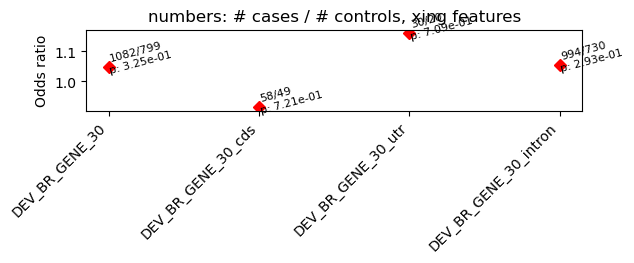

SVs intersecting DEV_BR_GENE_40: 317
SVs intersecting DEV_BR_GENE_40_cds: 34
SVs intersecting DEV_BR_GENE_40_utr: 14
SVs intersecting DEV_BR_GENE_40_intron: 269
case/control chi-squared p-values:
DEV_BR_GENE_40 DEV_BR_GENE_40_cds DEV_BR_GENE_40_utr DEV_BR_GENE_40_intron
6.12e-01 6.99e-01 5.56e-01 6.00e-01
notebook_svs/odds_ratio_dev_brain_40.png


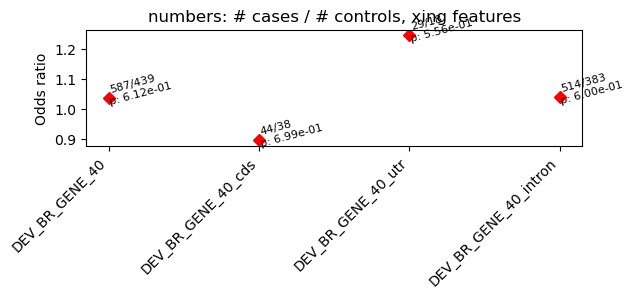

SVs intersecting DEV_BR_GENE_50: 246
SVs intersecting DEV_BR_GENE_50_cds: 27
SVs intersecting DEV_BR_GENE_50_utr: 12
SVs intersecting DEV_BR_GENE_50_intron: 207
case/control chi-squared p-values:
DEV_BR_GENE_50 DEV_BR_GENE_50_cds DEV_BR_GENE_50_utr DEV_BR_GENE_50_intron
3.41e-01 4.30e-01 6.99e-01 2.58e-01
notebook_svs/odds_ratio_dev_brain_50.png


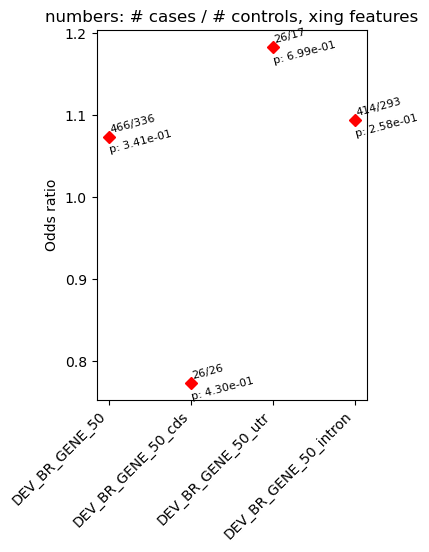

In [52]:
# plot enrichment in dev brain
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fts = lof_dev_br
fig_name = dir_fig+'odds_ratio_lof_dev_brain.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.005, dx2=0.02)

fts = dev_br_20
fig_name = dir_fig+'odds_ratio_dev_brain_20.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.005, dx2=0.02)

########## plot enrichment in features: fts ###########
fts = dev_br_30
fig_name = dir_fig+'odds_ratio_dev_brain_30.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=2, dx1=0.02, dx2=0.02)

########## plot enrichment in features: fts ###########
fts = dev_br_40
fig_name = dir_fig+'odds_ratio_dev_brain_40.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=2, dx1=0.02, dx2=0.02)

########## plot enrichment in features: fts ###########
fts = dev_br_50
fig_name = dir_fig+'odds_ratio_dev_brain_50.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.005, dx2=0.02)

total: (344736, 298)
filtered: (27669, 298)
SVs intersecting lncRNA: 5134
SVs intersecting miRNA: 49
SVs intersecting misc_RNA: 97
SVs intersecting processed_transcript: 162
SVs intersecting snoRNA: 27
SVs intersecting snRNA: 87
SVs intersecting TEC: 71
SVs intersecting protein_coding: 11435
case/control chi-squared p-values:
lncRNA miRNA misc_RNA processed_transcript snoRNA snRNA TEC protein_coding
2.74e-01 1.00e+00 3.59e-01 8.54e-01 2.62e-02 2.06e-01 6.52e-01 4.90e-01
notebook_svs/odds_ratio_biotypes.png


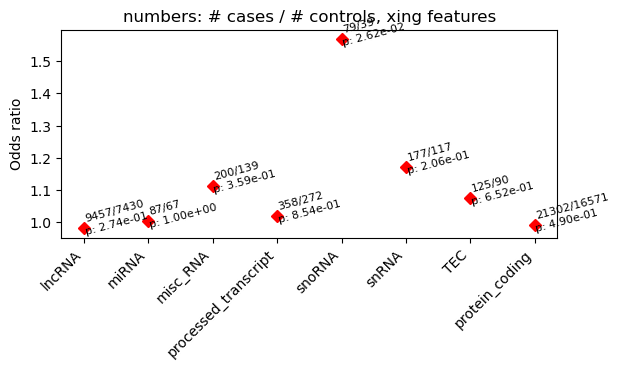

In [54]:
# plot enrichment in biotypes
fts = biotypes
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = dir_fig+'odds_ratio_biotypes.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=5, dx1=0.02, dx2=0.02)

total: (344736, 298)
filtered: (27669, 298)
SVs intersecting protein_coding_cds: 774
SVs intersecting protein_coding_utr: 360
SVs intersecting protein_coding_intron: 10301
SVs intersecting protein_coding_cds_pli: 116
SVs intersecting protein_coding_cds_loeuf: 73
SVs intersecting protein_coding_cds_fdr_asd: 9
SVs intersecting protein_coding_cds_fdr_dd: 15
SVs intersecting protein_coding_cds_fdr_ndd: 22
case/control chi-squared p-values:
protein_coding_cds protein_coding_utr protein_coding_intron protein_coding_cds_pli protein_coding_cds_loeuf protein_coding_cds_fdr_asd protein_coding_cds_fdr_dd protein_coding_cds_fdr_ndd
2.21e-01 1.00e+00 2.69e-01 4.38e-01 6.30e-01 8.09e-01 9.23e-01 1.00e+00
notebook_svs/odds_ratio_pc_subsec.png


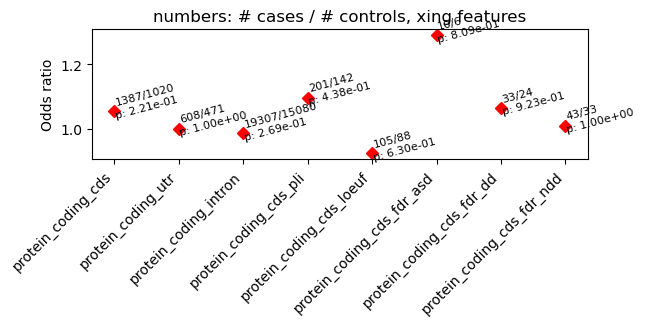

In [55]:
# plot enrichment in protein coding subsections
fts = pc_subsec
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = dir_fig+'odds_ratio_pc_subsec.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=5, dx1=0.02, dx2=0.02)

total: (344736, 298)
filtered: (27669, 298)
SVs intersecting PLI: 3253
SVs intersecting LOEUF: 2251
SVs intersecting FDR_ASD: 277
SVs intersecting FDR_DD: 574
SVs intersecting FDR_NDD: 807
case/control chi-squared p-values:
PLI LOEUF FDR_ASD FDR_DD FDR_NDD
8.60e-02 1.52e-01 9.13e-01 5.34e-01 2.10e-01
notebook_svs/odds_ratio_constrains_1.png


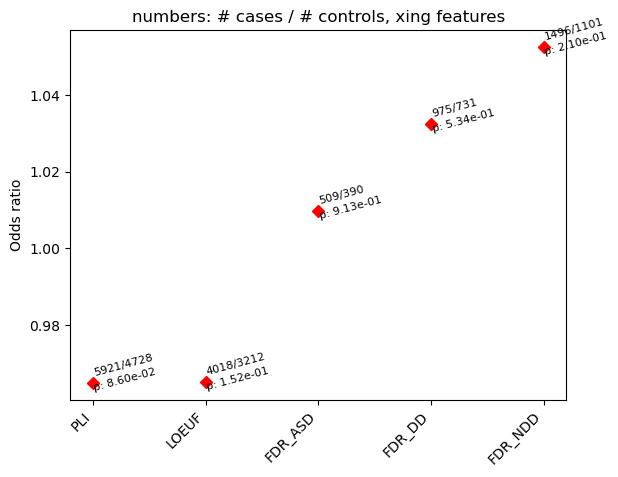

In [58]:
# plot enrichment in constrained annotations
fts = consts_1
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = dir_fig+'odds_ratio_constrains_1.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR='auto', dx1=0.002, dx2=0.002)

total: (344736, 298)
filtered: (27669, 298)
SVs intersecting FB_PR: 929
SVs intersecting FB_ENH: 1968
SVs intersecting FANTOM: 1117
SVs intersecting GNOCCHI_1: 5515
SVs intersecting GNOCCHI_2: 2732
SVs intersecting GNOCCHI_3: 1058
SVs intersecting GNOCCHI_4: 382
case/control chi-squared p-values:
FB_PR FB_ENH FANTOM GNOCCHI_1 GNOCCHI_2 GNOCCHI_3 GNOCCHI_4
5.17e-01 3.03e-01 7.92e-02 3.91e-01 9.61e-01 3.31e-01 2.76e-01
notebook_svs/odds_ratio_constrains_2.png


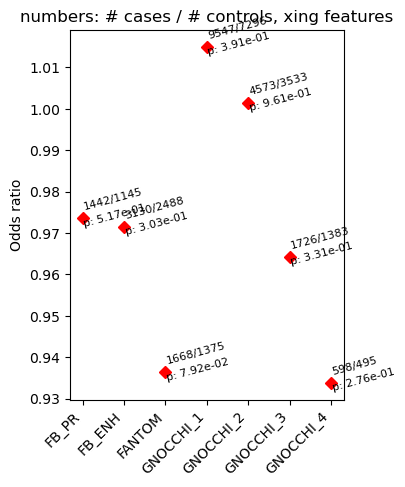

In [60]:
# plot enrichment in constrained annotations
fts = consts_2
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = dir_fig+'odds_ratio_constrains_2.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=100, dx1=0.002, dx2=0.002)

total: (344736, 298)
filtered: (27669, 298)
SVs intersecting PLI_cds: 116
SVs intersecting PLI_utr: 57
SVs intersecting PLI_intron: 3080
SVs intersecting LOEUF_cds: 73
SVs intersecting LOEUF_utr: 40
SVs intersecting LOEUF_intron: 2138
case/control chi-squared p-values:
PLI_cds PLI_utr PLI_intron LOEUF_cds LOEUF_utr LOEUF_intron
4.38e-01 4.47e-01 4.22e-02 6.30e-01 4.15e-01 1.37e-01
notebook_svs/odds_ratio_pli_loeuf_subset.png


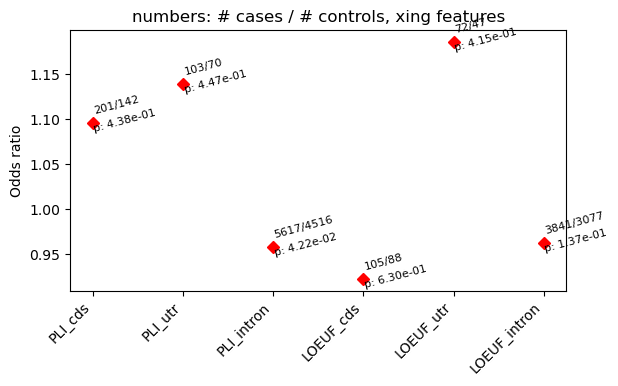

In [61]:
# plot enrichment in constrained subsets
fts = consts_subsec_1
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = dir_fig+'odds_ratio_pli_loeuf_subset.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.01, dx2=0.01)

total: (344736, 298)
filtered: (27669, 298)
SVs intersecting FDR_ASD_cds: 9
SVs intersecting FDR_ASD_utr: 4
SVs intersecting FDR_ASD_intron: 264
SVs intersecting FDR_DD_cds: 15
SVs intersecting FDR_DD_utr: 13
SVs intersecting FDR_DD_intron: 546
SVs intersecting FDR_NDD_cds: 22
SVs intersecting FDR_NDD_utr: 18
SVs intersecting FDR_NDD_intron: 767
case/control chi-squared p-values:
FDR_ASD_cds FDR_ASD_utr FDR_ASD_intron FDR_DD_cds FDR_DD_utr FDR_DD_intron FDR_NDD_cds FDR_NDD_utr FDR_NDD_intron
8.09e-01 1.00e+00 9.85e-01 9.23e-01 1.00e+00 5.55e-01 1.00e+00 8.85e-01 2.16e-01
notebook_svs/odds_ratio_fdr_subset.png


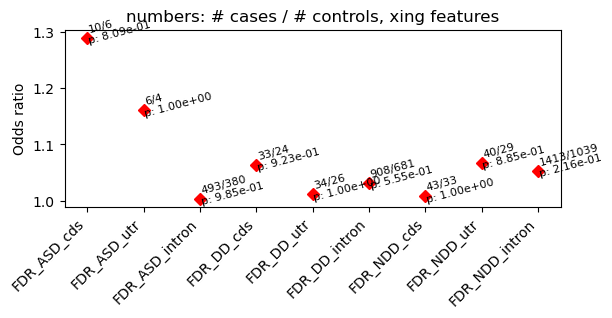

In [62]:
# plot enrichment in constrained subsets
fts = consts_subsec_2
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
fig_name = dir_fig+'odds_ratio_fdr_subset.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.01, dx2=0.01)

total: (344736, 298)
filtered: (27669, 298)
SVs intersecting FDR_ASD_cds: 9
SVs intersecting FDR_ASD_utr: 4
SVs intersecting FDR_ASD_intron: 264
SVs intersecting FDR_DD_cds: 15
SVs intersecting FDR_DD_utr: 13
SVs intersecting FDR_DD_intron: 546
SVs intersecting FDR_NDD_cds: 22
SVs intersecting FDR_NDD_utr: 18
SVs intersecting FDR_NDD_intron: 767
case/control chi-squared p-values:
FDR_ASD_cds FDR_ASD_utr FDR_ASD_intron FDR_DD_cds FDR_DD_utr FDR_DD_intron FDR_NDD_cds FDR_NDD_utr FDR_NDD_intron
8.67e-01 1.00e+00 5.15e-01 9.58e-01 1.00e+00 9.41e-01 8.00e-01 8.55e-01 4.89e-01
notebook_svs/odds_ratio_fdr_subset_AD2_SAMPLES.png


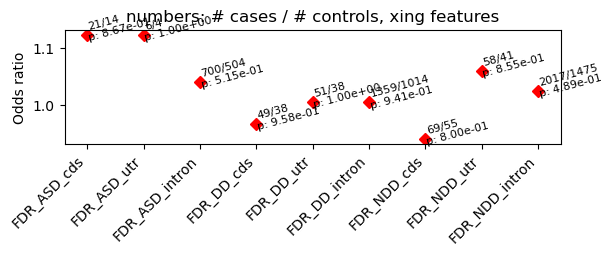

In [63]:
# plot enrichment in constrained subsets
fts = consts_subsec_2
flt_name = 'AD3_SAMPLES'
include_svtypes = ['INS', 'DEL', 'DUP', 'INV', '.']

# filter for main svtypes and quality
df_flt = get_df_flt(df, flt_name, include_svtypes, flt_sd_art=True, freq_thr=0.05)
print(f'total: {df.shape}')
print(f'filtered: {df_flt.shape}')

########## plot enrichment in features: fts ###########
flt_name = 'AD2_SAMPLES'
fig_name = dir_fig+'odds_ratio_fdr_subset_AD2_SAMPLES.png'
plot_enrich(df_flt, fts, flt_name, fig_name, AR=10, dx1=0.01, dx2=0.01)

In [11]:
# look into what svtypes have more missing coverages
sv_counts = df.SVTYPE.value_counts()
print(sv_counts)
print(sv_counts.sum())

missing_sv_counts = df.loc[df.NUM_ZERO_COV_SAMPLES > 40].SVTYPE.value_counts()
print(missing_sv_counts)
print(missing_sv_counts.sum())

for svtype in sv_counts.index:
    print(svtype)
    sum_all = sv_counts.sum()
    print(f'fraction: {sv_counts[svtype] / sum_all}')
    sum_missing = missing_sv_counts.sum()
    print(f'missing fraction: {missing_sv_counts[svtype] / sum_missing}')

SVTYPE
DEL    119503
INS    117958
BND     87599
INV     13671
DUP      3235
Name: count, dtype: int64
341966
SVTYPE
INS    10856
BND     8285
DEL     6482
INV      916
DUP      123
Name: count, dtype: int64
26662
DEL
fraction: 0.34945871811817547
missing fraction: 0.24311754557047482
INS
fraction: 0.34494072510132584
missing fraction: 0.4071712549696197
BND
fraction: 0.2561628933870619
missing fraction: 0.31074187982897006
INV
fraction: 0.03997765859763836
missing fraction: 0.03435601230215288
DUP
fraction: 0.009460004795798413
missing fraction: 0.004613307328782537


hist_FDR_DD_utr.png


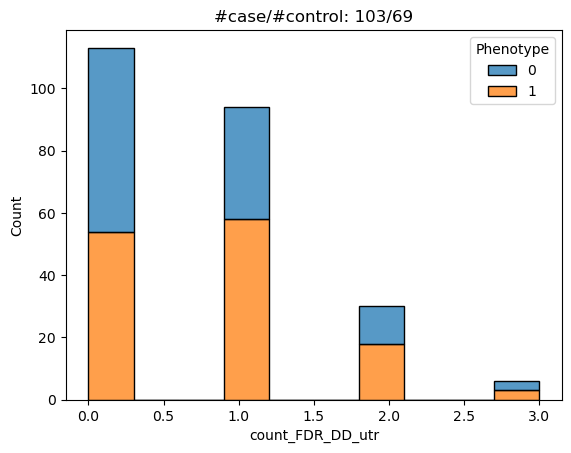

In [27]:
import seaborn as sb

ft = 'FDR_DD_utr'
df_main_copy = pd.DataFrame(df_main)
#df_main_copy[f'has_{ft}_var'] = df_main_copy[f'count_{ft}'] > 0
num_case = df_main_copy.loc[df_main_copy.Phenotype==1,f'count_{ft}'].sum()
num_control = df_main_copy.loc[df_main_copy.Phenotype==0,f'count_{ft}'].sum()

plt.figure()
#sb.scatterplot(data=df_main_copy, x='PC3', y='PC8', hue=f'has_{ft}_var')
sb.histplot(data=df_main_copy, x=f'count_{ft}', hue='Phenotype', multiple="stack")
plt.title(f'#case/#control: {num_case}/{num_control}')
fig_name = f'hist_{ft}.png'
print(fig_name)
plt.savefig(fig_name, bbox_inches='tight')
plt.show()